# Experience Calculator

In [1]:
# General initialization
simulation_timeframe = '2019'
ML_model1 = 'lasso'

In [2]:
# Global parameter initialization

if simulation_timeframe == '2017':
    # Define files
    teamstrength_filename = 'teamdata2017_strenghtparam'
    playerstrength_top_filename = 'playerdata2017_strenghtparam_top'
    playerstrength_mid_filename = 'playerdata2017_strenghtparam_mid'
    playerstrength_jun_filename = 'playerdata2017_strenghtparam_jun'
    playerstrength_adc_filename = 'playerdata2017_strenghtparam_adc'
    playerstrength_sup_filename = 'playerdata2017_strenghtparam_sup'
    culture_detection_splits = ['2016-W']
    filename = 'data2017_raw_model2'
    # Specify data range in scope
    scope_train_list = ['2017-2', '2017-2po', '2017-2rq', '2017-2pr', '2017-1', '2017-1po', '2017-1pr']
    scope_pred_list = ['2017-W']
    
elif simulation_timeframe == '2018':
    # Define files
    teamstrength_filename = 'teamdata2018_strenghtparam'
    playerstrength_top_filename = 'playerdata2018_strenghtparam_top'
    playerstrength_mid_filename = 'playerdata2018_strenghtparam_mid'
    playerstrength_jun_filename = 'playerdata2018_strenghtparam_jun'
    playerstrength_adc_filename = 'playerdata2018_strenghtparam_adc'
    playerstrength_sup_filename = 'playerdata2018_strenghtparam_sup'
    culture_detection_splits = ['2017-W']
    filename = 'data2018_raw_model2'
    # Specify data range in scope
    scope_train_list = ['2017-2', '2017-2po', '2017-2rq', '2017-2pr', '2017-1', '2017-1po', '2017-1pr', '2017-W',
                    '2018-1', '2018-1P', '2018-2', '2018-2p', '2018-2rq']
    scope_pred_list = ['2018-W']
    
elif simulation_timeframe == '2019':
    # Define files
    teamstrength_filename = 'teamdata2019_strenghtparam'
    preprocessed_filename = 'data2019_model2'
    playerstrength_top_filename = 'playerdata2019_strenghtparam_top'
    playerstrength_mid_filename = 'playerdata2019_strenghtparam_mid'
    playerstrength_jun_filename = 'playerdata2019_strenghtparam_jun'
    playerstrength_adc_filename = 'playerdata2019_strenghtparam_adc'
    playerstrength_sup_filename = 'playerdata2019_strenghtparam_sup'
    culture_detection_splits = ['2017-W', '2018-W']
    filename = 'data2019_raw_model2'
    # Specify data range in scope
    scope_train_list = ['2017-2', '2017-2po', '2017-2rq', '2017-2pr', '2017-1', '2017-1po',
                    '2017-1pr', '2017-W', '2018-1', '2018-1P', '2018-2rq', '2018-2', 
                    '2018-2p', '2018-W', '2019-1', '2019-1P', '2019-2']
    # Teams expected to go to worlds:
    teams_worlds_2019 = {'griffin', 
                     'g2 esports', 
                     'damwon gaming', 'funplus phoenix',
                     'fnatic', 'cloud9', 'invictus gaming', 'team liquid',
                     'sk telecom t1', 'royal never give up', 'ahq', 'schalke 04',
                     'gam esports', 'counter logic gaming', 'unicorns of love', 'j team',
                     'mad team', 'detonation focusme', 'intz', 'chiefs',
                     'isurus gaming', 'supermassive', 'team flash', 'detonator'}
    # No team data available: 'gam esports', 'chiefs', 'team flash', 'detonator'

## Load libraries and define functions

### 0.1 General python functionality

In [3]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
import operator
import itertools
from numpy.random import choice
from collections import Counter
import statistics
from datetime import datetime
from scipy import stats

# Functions used for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn import preprocessing

### 0.2 Custom functions

In [5]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 20, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    
        plt.savefig('Barplot_' + title + '.png')

In [6]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()
    plt.savefig('Frequency_' + title + '.png')

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()
    plt.savefig('Boxplot_' + title + '.png')

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()
    plt.savefig('Probabilityplot_' + title + '.png')

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [7]:
### Function used to draw a random sample from the discrete distribution of probabilities representing the input list
def RandomSampleProbDist(list_of_values, draws = 1):
    """
    :param: list_of_values (list): A list of categorical values representing the observations in the dataset
    :param: draws (int): The number of samples desired to be returned
    :return: (array) An array capturing the sampled categories
    """
    # Only the non-missing values are considered in the sampling procedure
    non_missing_list = list_of_values.dropna()
    # Sample from the discrete probability distribution representing the categorical variable
    return list(choice(list(Counter(non_missing_list)), 
                  draws, 
                  p = list(map(lambda x: x/len(non_missing_list), 
                               Counter(non_missing_list).values()))))[0]

In [8]:
### Function used for a boxcox transformation of input features
def feature_transformer(feature, featurename):
    """
    Visualizes the input feature before and after being boxcox transformed. Furthermore the transformed data,
    based on the optimal lambda estimated with the boxcox method is returned in a standardized fashion (zero mean
    and a variance of one)
    """
    # Boxcox transformation
    transformed_feature, optimizer = stats.boxcox(feature)
    standardized_feature, standardized_transformed_feature = preprocessing.scale(feature), preprocessing.scale(transformed_feature)
    # Visualization
    print("Feature: ", featurename)
    plt.figure()
    sns.kdeplot(standardized_feature, shade=True, label=featurename )
    sns.kdeplot(standardized_transformed_feature, shade=True, label= "Transformed " + featurename)
    plt.savefig('Transformed_' + featurename + '.png')
    print("The optimal value for lambda: ", optimizer)
    # Return transformed and standardized data
    return standardized_transformed_feature, optimizer

## 1. Load data in environment
To allow for the construction of team and player based synergy statistics, the data source as a whole was loaded in the environment.

### 1.1 Raw data

#### Read in raw data xlsx format

In [9]:
# Load the data and create panda's dataframe
pd_df_2016 = pd.ExcelFile('Data/2016-complete-match-data-OraclesElixir-2017-09-18.xlsx')
pd_df_2017 = pd.ExcelFile('Data/2017matchdataOraclesElixir.xlsx')
pd_df_2018_spring = pd.ExcelFile('Data/2018-spring-match-data-OraclesElixir-2018-05-20.xlsx')
pd_df_2018_summer = pd.ExcelFile('Data/2018 summer match data OraclesElixir 2018-09-27.xlsx')
pd_df_2018_worlds = pd.ExcelFile('Data/2018-worlds-match-data-OraclesElixir-2018-11-03.xlsx')
pd_df_2019_spring = pd.ExcelFile('Data/2019-spring-match-data-OraclesElixir-2019-05-21.xlsx')
pd_df_2019_summer = pd.ExcelFile('Data/2019-summer-match-data-OraclesElixir-2019-08-19.xlsx')

# Put the data in a dataframe
df_2016 = pd_df_2016.parse(0)
df_2017 = pd_df_2017.parse(0)
df_2018_spring = pd_df_2018_spring.parse(0)
df_2018_summer = pd_df_2018_summer.parse(0)
df_2018_worlds = pd_df_2018_worlds.parse(0)
df_2019_spring = pd_df_2019_spring.parse(0)
df_2019_summer = pd_df_2019_summer.parse(0)

# Check whether most recent datasets represent the same features
print(all(df_2017.columns == df_2018_spring.columns))
print(all(df_2017.columns == df_2018_summer.columns))
print(all(df_2017.columns == df_2018_worlds.columns))
print(all(df_2018_summer.columns == df_2019_summer.columns))
print(all(df_2017.columns == df_2019_summer.columns))

True
True
True
True
True


#### Concatenate dataframes

In [10]:
# Add extra column indicating the year of the data
df_2016['Year'] = ['2016' for i in range(len(df_2016))]
df_2017['Year'] = ['2017' for i in range(len(df_2017))]
df_2018_spring['Year'] = ['2018' for i in range(len(df_2018_spring))]
df_2018_summer['Year'] = ['2018' for i in range(len(df_2018_summer))]
df_2018_worlds['Year'] = ['2018' for i in range(len(df_2018_worlds))]
df_2019_spring['Year'] = ['2019' for i in range(len(df_2019_spring))]
df_2019_summer['Year'] = ['2019' for i in range(len(df_2019_summer))]

In [11]:
# Initialize data you want to analyse
data_exploration = pd.concat([df_2016, df_2017, df_2018_spring, df_2018_summer, df_2018_worlds, df_2019_spring, df_2019_summer])

/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### 1.2 Only retain team data from 1-1 matchups
Only team data is retained from matchups (based on the unique gameid identifier) in which two teams played against each other. 

In [12]:
# Retain team level parameter information
data_exploration = data_exploration[data_exploration.position != 'Team']

In [13]:
# Create dictionary capturing the team and its opponent during a matchup
matchup_dict = {}
for gameID in list(set(data_exploration.gameid)):
    matchup_df = data_exploration[data_exploration.gameid == gameID]
    matchup_dict[gameID] = set(matchup_df.team)

In [14]:
# Intermediate summary
print("The number of teams corresponding to the same game-id in the dataset:")
matchup_dict_counter = Counter([len(x) for x in matchup_dict.values()])
for ID, teams in matchup_dict_counter.items():
    print(ID, ":", teams)
print("\nWe are only interested in games involving two teams and hence removed the others from further analysis:")
print("Latter allowed us to retain", round(matchup_dict_counter[2]/sum(matchup_dict_counter.values())*100, 4) ,"% of the initial matchup data")
print("Information from", matchup_dict_counter[2], "are retained in the final dataset")

The number of teams corresponding to the same game-id in the dataset:
0 : 1
2 : 10064
4 : 98
3 : 2

We are only interested in games involving two teams and hence removed the others from further analysis:
Latter allowed us to retain 99.0064 % of the initial matchup data
Information from 10064 are retained in the final dataset


In [15]:
# Remove biased match-up data
unbiased_gameids = [gameID for gameID, teams in matchup_dict.items() if len(teams) == 2]
data_exploration = data_exploration[data_exploration['gameid'].isin(unbiased_gameids)]

### 1.3 Proper feature adjustment
#### 1.3.1 Adjust Team and player parameter in dataset
The parameter describing the player was lowercased and the bias in spelling mistakes made and the use of different names to indicate the same player and was removed by manually exploring the data and creating a matching dictionary. All the players were retained in the final dataset (also the ones for which no strength parameters will be calculated) to allow us to build a model on as much data as possible. Latter preprocessing was considered as well for the team parameter.

In [16]:
# Adjust the player parameter in the data
list_of_players = [x.lower() if isinstance(x, str) else x for x in data_exploration.player]
data_exploration = data_exploration.drop(['player'], axis= 1)
data_exploration["player"] = list_of_players

In [17]:
# Team matching dictionary
team_dict = {'100 thieves': ['100 thieves', '100 thieves academy'],
             'ahq': ['ahq e-sports club', 'ahq fighter'],
             'apex': ['apex', 'apex pride'],
             'big gods': ['big gods esports', 'big gods jackals'],
             'cloud9': ['cloud9', 'cloud9 academy', 'cloud9 challenger'],
             'clutch gaming': ['clutch gaming', 'clutch gaming academy'],
             'counter logic gaming': ['counter logic gaming', 'clg academy'],
             'echo fox': ['echo fox', 'echo fox academy'],
             'extreme gamers': ['extreme gamers', 'extreme gamers esports club'],
             'flyquest': ['flyquest', 'flyquest academy'],
             'fnatic': ['fnatic', 'fnatic academy'],
             'flamengo': ['flamengo', 'flamengo esports'],
             'giants': ['giants', 'giants gaming'],
             'golden guardians': ['golden guardians', 'golden guardians academy'],
             'intz': ['intz', 'intz e-sports', 'intz e-sports club'],
             'kabum': ['kabum e-sports', 'kabum esports'],
             'kongdoo monster': ['kongdoo mongster', 'kongdoo monster'],
             'machi17' : ['machi17', 'machi 17'],
             'misfits': ['misfits', 'misfits academy'],
             'optic': ['optic academy', 'optic gaming'],
             'qg reapers': ['qg reapers', 'qiao gu reapers'],
             'redemption': ['redemption', 'redemption esports'],
             'rogue': ['rogue', 'rogue warriors'],
             'suning': ['suning', 'suning gaming'],
             'supermassive': ['supermassive', 'supermassive esports'],
             'team liquid': ['team liquid', 'team liquid academy'],
             'team one': ['team one e-sports', 'team one esports'],
             'top esports': ['top esports', 'topsports gaming']}

team_match_dict = {v:k for k, v_list in team_dict.items() for v in v_list}

In [18]:
# Adjust the team parameter in the data
list_of_teams = [x.lower() for x in data_exploration.team]
data_exploration = data_exploration.drop(['team'], axis= 1)
unbiased_teamlist = [team_match_dict[team] if team in team_match_dict else team for team in list_of_teams]
data_exploration["team"] = unbiased_teamlist

### 1.4 Extra feature creation
#### 1.4.1 Culture

In [19]:
# Create dictionary matching the league with its corresponding culture
culture_dict = {'CBLoL': 'Brazil', 'EULCS': 'Europe', 'LCK': 'Korea',
                'LMS': 'Taiwan, Hong Kong & Macau', 'LPL': 'China',
                'NALCS': 'North America', 'TCL': 'Turkey',
                'LCL': 'Commonwealth of Independent States', 'LJL': 'Japan',
                'LLN': 'Latin America - North', 'OPL': 'Oceania', 
                'GPL': 'Southeast Asia', 'VCS': 'Vietnam',
                'WC': 'International', 'MSI': 'International',
                'EUPR': 'Europe', 'NAAc': 'North America',
                'EUCS': 'Europe', 'NAPR': 'North America',
                'NACS': 'North America'}

data_exploration['culture'] = [culture_dict[l] if l in culture_dict else np.nan for l in data_exploration['league']]

# Intermediate summary
if not set(data_exploration['league']).issubset(set(culture_dict.keys())):
    print("Not all leagues could be represented by the dictionary used, the ones for which no match was found: ",
          set(data_exploration['league']) - set(culture_dict.keys()))

Not all leagues could be represented by the dictionary used, the ones for which no match was found:  {'KeSPA', 'NA PR', 'LCS', 'LEC', 'LCK PR', 'RRNAEU', 'RRAsia', 'EU PR', 'IWCQ', 'IWCI'}


To incorporate the influence of culture in our calculation a culture score based on previous worlds competition is added.

In [20]:
# Create dictionary mapping each team with its corresponding region
subdata = data_exploration[data_exploration.culture != 'International']
team_culture_mapping_dict = dict((zip(subdata.team, subdata.culture)))
    
# Calculate region dependent win-probability on worlds
worlds_subdata = data_exploration[data_exploration.split.isin(culture_detection_splits)]
match_outcome_list = [(team_culture_mapping_dict[team], result) for team, result in zip(worlds_subdata.team, worlds_subdata.result) if team in team_culture_mapping_dict]
culture_score_mapping_dict = dict()
for culture in list(set([x[0] for x in match_outcome_list])):
    culture_score_total = 0
    for cult, score in match_outcome_list:
        if culture == cult: 
            culture_score_total += score
    culture_score_mapping_dict[culture] = culture_score_total
culture_score_mapping_dict.pop(np.nan)
        
# Add culture score as extra feature to final database
data_exploration['culture_score'] = [culture_score_mapping_dict[team_culture_mapping_dict[team]] if team in team_culture_mapping_dict and team_culture_mapping_dict[team] in culture_score_mapping_dict else np.nan for team in data_exploration['team']]

In [21]:
# Visualize ranking dictionary
culture_score_mapping_dict

{'North America': 10,
 'Brazil': 20,
 'Turkey': 55,
 'Korea': 210,
 'China': 295,
 'Taiwan, Hong Kong & Macau': 80}

In [22]:
# Remove 2016 due to irrelevance
data_exploration = data_exploration[~data_exploration.Year.isin(['2016'])]

#### 1.4.2 Recency of game played

In [23]:
# Time indicator (days since game was last played)
dates = [datetime.utcfromtimestamp((x- 25569) * 86400.0) if isinstance(x, float) else datetime.utcfromtimestamp(0) for x in data_exploration["date"]]

# Calculate the date difference with today
daydiff = [(datetime.now() - x).days if not x == datetime.utcfromtimestamp(0) else np.NaN for x in dates]


# At column with date difference indicator to the dataframe and drop unicode indications 
data_exploration["datediff"] = daydiff
data_exploration = data_exploration.drop(['date'], axis= 1)

#### 1.4.3 Match importance
In the data the following abbreviations are used to define the split: The year the game was played combined with a specific suffix (1 spring, 2 summer, po playoffs, r regionals, w worlds). Based on expert knowledge a matchimportance ranking was done.

In [24]:
# Initialization of match importance
match_imp_dict = {'1':1, '2':2, 'W':4, 'po':1.5, '2017':1, '2018':2, '2018':2, '2019': 3}

# Extract rank information needed to process match importance
matchimp_list = [s.split('-') for s in set(data_exploration['split']) if s != 'nan']

# Create dictionary for mapping
match_imp_mapping_dict = dict()
for year, split in matchimp_list:
    playoff = match_imp_dict['po'] if any(s in split for s in ['po', 'rq', 'pr']) else 1
    match_imp_mapping_dict[year + '-' + split] = match_imp_dict[year] * match_imp_dict[split[0]] *playoff    

# Map the values of the dataframe for the different patch numbers
data_exploration['split_ind'] = [match_imp_mapping_dict[s] if s in match_imp_mapping_dict else np.nan for s in data_exploration['split']]

#### 1.4.4 Patch number
The patch number will be ranked in an ordinal fashion, giving higher values to more recent patches. There was no magnitude based ranking used because of its irrelevance for this specific situation.

In [25]:
# Extract rank information needed to process patch number
patchno_split_list = [str(patchno).split('.') for patchno in set(data_exploration['patchno']) if any(char.isdigit() for char in str(patchno))]
patchno_split_list = [[int(p), int(n)] if len(n) == 2 else [int(p), int(n + '0')] for p, n in patchno_split_list]
patch_sorted, no_sorted = sorted(list(set([p for p, n in patchno_split_list]))), sorted(list(set([n for p, n in patchno_split_list])))

# Create dictionary for mapping
patchno_mapping_dict, counter = dict(), 0
for patch in patch_sorted:
    for no in no_sorted:
        # Customize patch number
        if len(str(no)) == 1:
            custom_no = '0' + str(no)
        elif str(no)[-1] == '0':
            custom_no = str(no)[:-1]
        else: 
            custom_no = str(no)
        # Fill matching dictionary
        patchno_mapping_dict[str(patch) + '.' + custom_no] = counter
        counter += 1

# Map the values of the dataframe for the different patch numbers
data_exploration['patchno'] = [patchno_mapping_dict[str(patchno)] if str(patchno) in patchno_mapping_dict else np.nan for patchno in data_exploration['patchno']]

## 2 Data filtering

In [26]:
# Teams going to worlds
teams_worlds_2019 = {'griffin', 
                     'g2 esports', 
                     'damwon gaming', 'funplus phoenix',
                     'fnatic', 'cloud9', 'invictus gaming', 'team liquid',
                     'sk telecom t1', 'royal never give up', 'ahq', 'schalke 04',
                     'gam esports', 'counter logic gaming', 'unicorns of love', 'j team',
                     'mad team', 'detonation focusme', 'intz', 'chiefs',
                     'isurus gaming', 'supermassive', 'team flash', 'detonator'}
#'gam esports', 'chiefs', 'team flash', 'detonator'

In [27]:
# Players going to worlds
players_worlds_2019, playerteam_matching_dict, playerrole_matching_dict = [], dict(), dict()
for team in teams_worlds_2019:
    playerrole_matching_list = []
    if team in set(data_exploration.team):
        #players = data_exploration[data_exploration.team == team]['player'].unique()
        subdat = data_exploration[data_exploration.team == team]
        for pos in subdat['position'].unique():
            games_played_dict = dict()
            for player in subdat[(subdat.position == pos) & (subdat.split.isin(['2019-1', '2019-1P', '2019-2', '2019-2P']))]['player'].unique():
                games_played_dict[player] = len(subdat[(subdat.player == player)])
            if games_played_dict:
                players_worlds_2019.append(max(games_played_dict.items(), key=operator.itemgetter(1))[0])
                playerrole_matching_list.append(max(games_played_dict.items(), key=operator.itemgetter(1))[0])
                playerrole_matching_dict[max(games_played_dict.items(), key=operator.itemgetter(1))[0]] = pos.lower()
                playerteam_matching_dict[team] = playerrole_matching_list
            #print('Team ', team, '- role', pos,' - player: ', games_played_dict, '-max', max(games_played_dict.items(), key=operator.itemgetter(1))[0])

In [28]:
# Define training and prediction data in scope 
train_subset = data_exploration[data_exploration.split.isin(scope_train_list)]

# Intermediate summary
print("The data for training captures information of", len(train_subset.gameid.unique()), 'games. Representing',
      len(train_subset.team.unique()), "different teams and", len(train_subset.player.unique()), "different players.")
print("The data for prediction represents",
      len(teams_worlds_2019), "different teams and", len(players_worlds_2019), "different players.\n")

print("Mapping should be possible for", len(set(train_subset.team).intersection(set(teams_worlds_2019))), "teams in the prediction dataset. The teams not represented are:", set(teams_worlds_2019) - set(train_subset.team), "\n")
print("Furthermore, mapping should be possible for", len(set(train_subset.player).intersection(set(players_worlds_2019))), "players in the prediction dataset. The players not represented are:", set(players_worlds_2019) - set(train_subset.player))

The data for training captures information of 7728 games. Representing 151 different teams and 1130 different players.
The data for prediction represents 24 different teams and 90 different players.

Mapping should be possible for 20 teams in the prediction dataset. The teams not represented are: {'chiefs', 'team flash', 'detonator', 'gam esports'} 

Furthermore, mapping should be possible for 87 players in the prediction dataset. The players not represented are: set()


In [29]:
# Create a team-and culturescore mapping dictionary
mean_cult_score = np.mean(train_subset.culture_score.dropna())
team_culturescore_mapping_dict = dict()

# Mean imputation is considered for the culture score represented by teams for which no data is available
for team, cult_score in zip(train_subset.team, train_subset.culture_score):
    if team in list(teams_worlds_2019):
        if team in team_culture_mapping_dict:
            team_culturescore_mapping_dict[team] = cult_score
        else:
            team_culturescore_mapping_dict[team] = mean_cult_score

# The teams from the challenger series are assigned missing values
for team in list(set(teams_worlds_2019) - set(team_culturescore_mapping_dict)):
    team_culturescore_mapping_dict[team] = np.nan

# Intermediate summary
print("The teams going to the worlds competition and their corresponding culture score:\n", team_culturescore_mapping_dict)

The teams going to the worlds competition and their corresponding culture score:
 {'sk telecom t1': 210.0, 'fnatic': nan, 'g2 esports': nan, 'unicorns of love': nan, 'cloud9': nan, 'counter logic gaming': nan, 'j team': 80.0, 'team liquid': nan, 'ahq': 80.0, 'intz': 20.0, 'invictus gaming': 295.0, 'royal never give up': 295.0, 'supermassive': 55.0, 'schalke 04': nan, 'isurus gaming': nan, 'mad team': 80.0, 'funplus phoenix': 295.0, 'griffin': 210.0, 'detonation focusme': nan, 'damwon gaming': 210.0, 'chiefs': nan, 'team flash': nan, 'detonator': nan, 'gam esports': nan}


## 3. Dataframe creation for modelling
The following parameters are integrated in the second model:

***Team/ Opponent strenght parameters***
* Team strenght (x1)
* Opponent strenght (x1)
* Team top/Mid/Jgl/Sup/Adc player strenght (x5)
* Opponent top/Mid/Jgl/Sup/Adc player strenght (x5)

***Team/ Opponent synergy/ experience parameters***
* Team top/Mid/Jgl/Sup/Adc player experience with team going to worlds (x5): Number of times a player has played in that team
* Opponent top/Mid/Jgl/Sup/Adc player experience with team going to worlds (x5): Number of times a player has played in that team
* Team top/Mid/Jgl/Sup/Adc player experience with the structure of his team (x5): Number of times the player has played with at least 4 players of the team structure applied in worlds
* Opponent top/Mid/Jgl/Sup/Adc player experience with the structure of his team (x5): Number of times the player has played with at least 4 players of the team structure applied in worlds
* Team top/Mid/Jgl/Sup/Adc player general experience (x5): The number of games the player has played in his professional career
* Opponent top/Mid/Jgl/Sup/Adc player general experience (x5): The number of games the player has played in his professional career
* Team top/Mid/Jgl/Sup/Adc player experience with different teams (x5): The number of teams the player has played in 
* Opponent top/Mid/Jgl/Sup/Adc player experience with different teams (x5): The number of teams the player has played in 
* Team top/Mid/Jgl/Sup/Adc player experience within other teams but not the one in which he will go to worlds (x5): Number of times a player has played within other teams than the one in which he will go to worlds
* Opponent top/Mid/Jgl/Sup/Adc player experience within other teams but not the one in which he will go to worlds (x5): Number of times a player has played within other teams than the one in which he will go to worlds

***Team/ Opponent coach experience***
* Team coach years of experience (x1)
* Opponent coach years of experience (x1)

The total number of paramters created for the second model are 64.

### 3.1 Extract team/player strenght parameters
Latter information is extracted for all teams going to the worlds championship.

#### 3.1.1 Team strength parameter

In [30]:
# Load pickles
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + teamstrength_filename + '.pickle', 'rb') as f:
    team_strenght_df = pickle.load(f)

In [31]:
# Extract team information for teams going to worlds
team_list = set(train_subset.team.unique()).intersection(set(team_strenght_df.index))
team_strenght_df = team_strenght_df.loc[team_list, :]
team_strenght_df['Team'] = list(team_strenght_df.index)
team_strenght_df.head(5)

,accuracy indicator,lasso,ridge,result,Team
lgd gaming,239,0.111519,0.448831,0.389121,lgd gaming
pentagram,6,0.002561,0.351023,0.166667,pentagram
ksv esports,46,0.136987,0.446163,0.500000,ksv esports
bilibili gaming,166,0.472458,0.505421,0.518072,bilibili gaming
gigabyte marines,32,0.398093,0.483250,0.468750,gigabyte marines


In [32]:
# Rename column values
renaming_dict = {col_name: 'team_' + col_name for col_name in team_strenght_df.columns if col_name != 'Team'}
team_strenght_df.rename(columns= renaming_dict, inplace=True)

Information of 20 teams from the 24 teams in the prediction dataset are captured.


Overview of variable:  accuracy indicator 


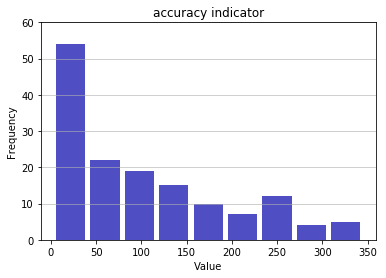

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3
Mean: 102.8446
Standard deviation: 90.3912
Median: 75.0
Maximal value: 345


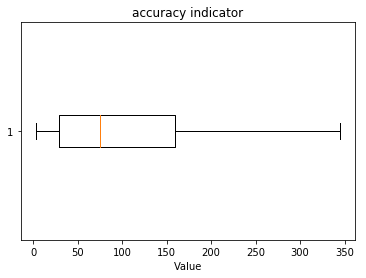

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


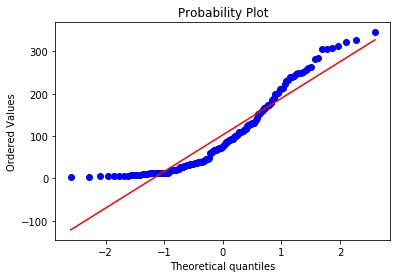

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8908
Kurtosis: -0.2543


<Figure size 432x288 with 0 Axes>

In [33]:
# Intermediate summary
print("Information of", len(set(team_strenght_df.Team).intersection(set(teams_worlds_2019))),"teams from the", len(set(teams_worlds_2019)),
      "teams in the prediction dataset are captured.\n\n")

# The accuracy estimation of the strenght parameters used
SummaryNumericVar(team_strenght_df['team_accuracy indicator'], 'accuracy indicator')

In [34]:
# Challengerseries teams
challengerseries_team_set = set(teams_worlds_2019) - set(team_strenght_df.Team)
print("The teams coming from the challenger series to participate in the worlds competition:\n", challengerseries_team_set)

The teams coming from the challenger series to participate in the worlds competition:
 {'chiefs', 'team flash', 'detonator', 'gam esports'}


In [35]:
# The accuracy parameter will not be considered during modelling and hence dropped for furter analysis
team_strenght_df = team_strenght_df.drop(['team_accuracy indicator'], axis=1)

In [36]:
# Select strength indicator based on ML_model 1 initialization
cols_to_drop = [col for col in team_strenght_df.columns if col not in ['Team', 'team_' + ML_model1]] 
team_strenght_df = team_strenght_df.drop(cols_to_drop, axis=1)

#### 3.1.2 Player strength parameter

In [37]:
# Initialization
positions_list = ['top', 'middle', 'jungle', 'adc', 'support']

In [38]:
# Load pickles
player_strenght_dict = dict()
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + playerstrength_top_filename + '.pickle', 'rb') as f:
    player_strenght_dict['top'] = pickle.load(f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + playerstrength_mid_filename + '.pickle', 'rb') as f:
    player_strenght_dict['middle'] = pickle.load(f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + playerstrength_jun_filename + '.pickle', 'rb') as f:
    player_strenght_dict['jungle'] = pickle.load(f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + playerstrength_adc_filename + '.pickle', 'rb') as f:
    player_strenght_dict['adc'] = pickle.load(f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + playerstrength_sup_filename + '.pickle', 'rb') as f:
    player_strenght_dict['support'] = pickle.load(f)

In [39]:
# Add position indicator and player name to dataset
for pos in positions_list:
    player_list = set(train_subset.player.unique()).intersection(set(player_strenght_dict[pos].index))
    player_strenght_dict[pos] = player_strenght_dict[pos].loc[player_list, :]
    player_strenght_dict[pos]['Player'] = list(player_strenght_dict[pos].index)
    player_strenght_dict[pos]['position'] =  pos

# Merge datasets
player_strenght_df = pd.concat([player_strenght_dict[pos] for pos in positions_list])
player_strenght_df.head(5)

,accuracy indicator,lasso,ridge,result,Player,position
bobo,20,0.362975,0.488606,0.450000,bobo,top
langx,31,0.615061,0.525213,0.741935,langx,top
doran,19,0.973607,0.591285,0.684211,doran,top
smoke,20,0.012412,0.384713,0.250000,smoke,top
wunder,207,0.873346,0.555865,0.594203,wunder,top


In [40]:
# Rename column values
renaming_dict = {col_name: 'player_' + col_name for col_name in player_strenght_df.columns if col_name != 'Player'}
player_strenght_df.rename(columns= renaming_dict, inplace=True)

Information of 87 players from the 87 players in the prediction dataset are captured.


Overview of variable:  accuracy indicator 


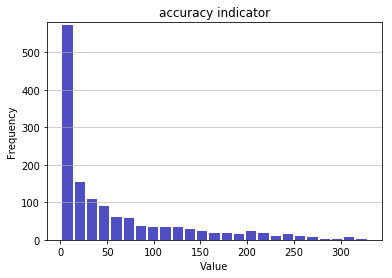

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1
Mean: 55.6695
Standard deviation: 70.5632
Median: 22.5
Maximal value: 329


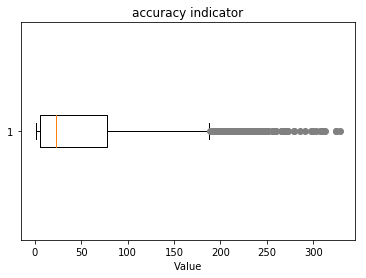

-------------------- 
Outlier detection:
 --------------------
List of outliers: {291, 324, 325, 329, 298, 300, 270, 303, 272, 273, 307, 309, 310, 279, 313, 286}


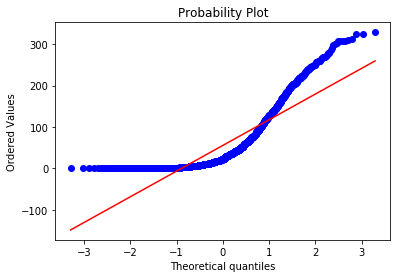

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.6001
Kurtosis: 1.8615


<Figure size 432x288 with 0 Axes>

In [41]:
# Intermediate summary
print("Information of",  len(set(player_strenght_df.Player).intersection(set(players_worlds_2019))), "players from the", len(set(players_worlds_2019)),
      "players in the prediction dataset are captured.\n\n")

# The accuracy estimation of the strenght parameters used
SummaryNumericVar(player_strenght_df['player_accuracy indicator'], 'accuracy indicator')

In [42]:
# The accuracy parameter will not be considered during modelling and hence dropped for furter analysis
player_strenght_df = player_strenght_df.drop(['player_accuracy indicator'], axis=1)

In [43]:
# Select strength indicator based on ML_model 1 initialization
cols_to_drop = [col for col in player_strenght_df.columns if col not in ['Player', 'player_position', 'player_'+ ML_model1]] 
player_strenght_df = player_strenght_df.drop(cols_to_drop, axis=1)

###  3.2 Create synergy/ experience parameters
Remark: There can be a small bias in this calculation due to the fact that teams change names sometimes and players could change names as well. We do not expect the impact of the latter to be tremendous on our model because they will not bias our view of the most recent changes (of course a double check-up will be needed). Furthermore, teamnames and structures often tend to change after a worlds championship and not before.
#### 3.2.1 Parameter creation

In [44]:
# Dictionary initialization
synergy_param_dict = dict()
team_list, player_list, player_experience_current_team_list, player_experience_teamcomposition_list, player_experience_general_list, player_experience_other_teams_list, player_strategy_list = [], [], [], [], [], [], []

# Loop through the different teams
for teller, t in enumerate(teams_worlds_2019):
    print(teller, '-', t)
    for p in players_worlds_2019:
        # 0. Team- player initialization
        team_list.append(t)
        player_list.append(p)
        # i. The number of games player has already played within current team
        if p in list(train_subset.player) and t in list(train_subset.team):
            player_experience_current_team_list.append(len(train_subset[(train_subset.team == t) & (train_subset.player == p)]['gameid'].unique()))
        else: 
            player_experience_current_team_list.append(np.nan)
        # ii. The number of games team has already played with current structure
        player_experience_teamcomposition = 0
        if p in list(train_subset.player) and t in list(train_subset.team):
            teamcomposition_worlds = set(players_worlds_2019)
            for gameid in train_subset[train_subset.team == t]['gameid'].unique():
                if len(set(train_subset[train_subset.gameid == gameid]['player']).intersection(teamcomposition_worlds)) >= 4:
                    player_experience_teamcomposition += 1
            player_experience_teamcomposition_list.append(player_experience_teamcomposition)
        else:
            player_experience_teamcomposition_list.append(np.nan)
        # iii. The numer of games the player has played
        if p in list(train_subset.player):
            player_experience_general_list.append(len(train_subset[train_subset.player == p]['gameid'].unique()))
        else: 
            player_experience_general_list.append(np.nan)
        # iv. The number of games player has already played within different teams
        if p in list(train_subset.player):
            player_experience_other_teams_list.append(len(train_subset[(train_subset.team != t) & (train_subset.player == p)]['gameid'].unique()))
        else: 
            player_experience_other_teams_list.append(np.nan)
        # v. The number of different teams the player has already played in
        if p in list(train_subset.player):
            player_strategy_list.append(len(train_subset[train_subset.player == p]['team'].unique()))
        else: 
            player_strategy_list.append(np.nan)

0 - team flash
1 - cloud9
2 - fnatic
3 - detonation focusme
4 - detonator
5 - unicorns of love
6 - ahq
7 - team liquid
8 - counter logic gaming
9 - j team
10 - schalke 04
11 - supermassive
12 - damwon gaming
13 - invictus gaming
14 - griffin
15 - isurus gaming
16 - g2 esports
17 - sk telecom t1
18 - gam esports
19 - royal never give up
20 - intz
21 - chiefs
22 - mad team
23 - funplus phoenix


In [45]:
# Pandas dataframe creation
synergy_param_dict['Team'] = team_list
synergy_param_dict['Player'] = player_list
synergy_param_dict['Player_experience_current_team'] = player_experience_current_team_list
synergy_param_dict['Player_experience_teamcomposition'] = player_experience_teamcomposition_list
synergy_param_dict['Player_experience_general'] = player_experience_general_list
synergy_param_dict['Player_experience_other_teams'] = player_experience_other_teams_list
synergy_param_dict['Player_strategy'] = player_strategy_list
synergy_param_df = pd.DataFrame(synergy_param_dict)

In [46]:
# Data visualization
synergy_param_df.head(10)

,Team,Player,Player_experience_current_team,Player_experience_teamcomposition,Player_experience_general,Player_experience_other_teams,Player_strategy
0,team flash,licorice,NaN,NaN,172,172,2
1,team flash,svenskeren,NaN,NaN,233,233,2
2,team flash,goldenglue,NaN,NaN,103,103,2
3,team flash,sneaky,NaN,NaN,237,237,1
4,team flash,zeyzal,NaN,NaN,176,176,2
5,team flash,bwipo,NaN,NaN,108,108,2
6,team flash,broxah,NaN,NaN,225,225,1
7,team flash,hylissang,NaN,NaN,216,216,2
8,team flash,rekkles,NaN,NaN,220,220,1
9,team flash,rekkles,NaN,NaN,220,220,1


In [47]:
# Short intermediate summary
print("The final dataset captures information from", len(synergy_param_df.columns), "features.")
print("In total, there are", len(synergy_param_df), "observations present in the dataframe, capturing the information from",
      len(set(synergy_param_df.Team)), "different teams and", len(set(synergy_param_df.Player)), "different players.")

The final dataset captures information from 7 features.
In total, there are 2160 observations present in the dataframe, capturing the information from 24 different teams and 87 different players.


---------------------------------------------------------------------------------------------------- 
Overview of variable:  Team 
 ----------------------------------------------------------------------------------------------------
Total categories: 24 

The 10 with the highest percentage data available:

funplus phoenix : 4.1667 %
mad team : 4.1667 %
chiefs : 4.1667 %
intz : 4.1667 %
royal never give up : 4.1667 %
gam esports : 4.1667 %
sk telecom t1 : 4.1667 %
g2 esports : 4.1667 %
isurus gaming : 4.1667 %
griffin : 4.1667 %

The 10 with the lowest percentage data available:

j team : 4.1667 %
counter logic gaming : 4.1667 %
team liquid : 4.1667 %
ahq : 4.1667 %
unicorns of love : 4.1667 %
detonator : 4.1667 %
detonation focusme : 4.1667 %
fnatic : 4.1667 %
cloud9 : 4.1667 %
team flash : 4.1667 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  Player 
 -------------------------------------------------------

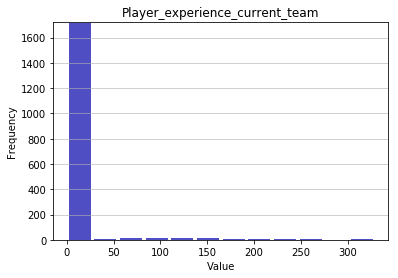

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 6.5639
Standard deviation: 32.9374
Median: 0.0
Maximal value: 329.0


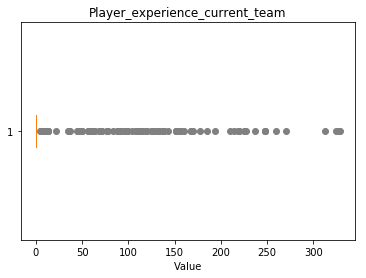

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, 131.0, 260.0, 133.0, 138.0, 139.0, 270.0, 143.0, 152.0, 153.0, 156.0, 157.0, 160.0, 168.0, 170.0, 177.0, 313.0, 185.0, 194.0, 325.0, 328.0, 329.0, 210.0, 214.0, 219.0, 220.0, 248.0, 225.0, 227.0, 108.0, 237.0, 112.0, 114.0, 116.0, 119.0, 120.0, 125.0, 127.0}


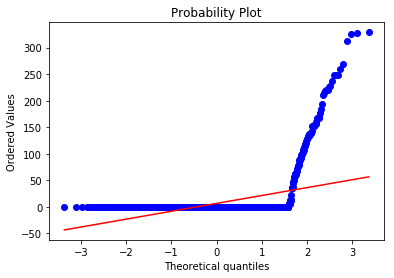

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 6.0242
Kurtosis: 40.1498
Overview of variable:  Player_experience_teamcomposition 


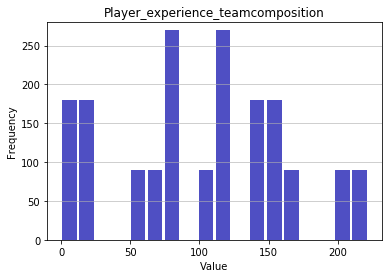

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 102.1
Standard deviation: 62.3446
Median: 109.5
Maximal value: 222.0


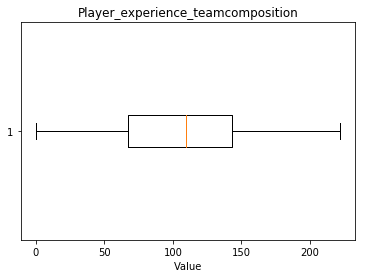

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


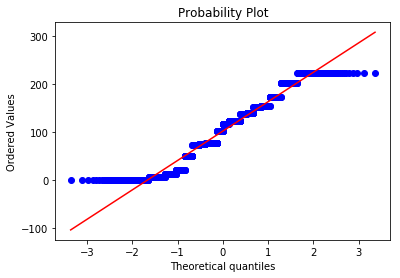

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0206
Kurtosis: -0.818
Overview of variable:  Player_experience_general 


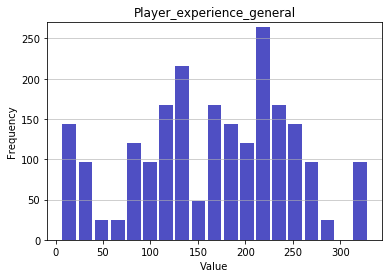

-------------------- 
Summary statistics:
 --------------------
Minimum value: 6
Mean: 165.5778
Standard deviation: 81.6129
Median: 173.0
Maximal value: 329


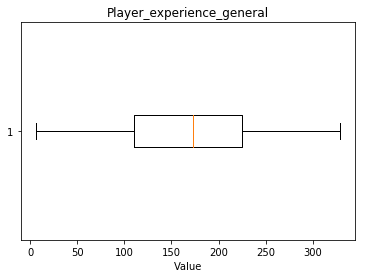

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


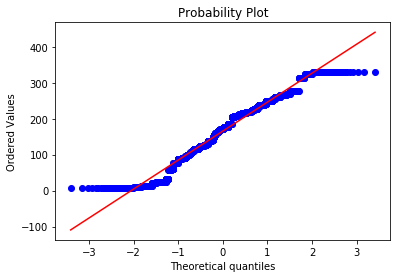

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2111
Kurtosis: -0.6549
Overview of variable:  Player_experience_other_teams 


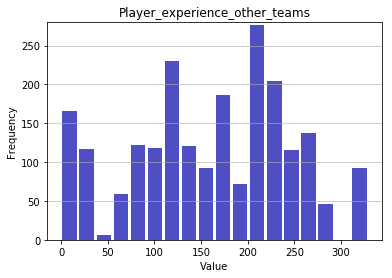

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 160.1079
Standard deviation: 84.4677
Median: 170.0
Maximal value: 329


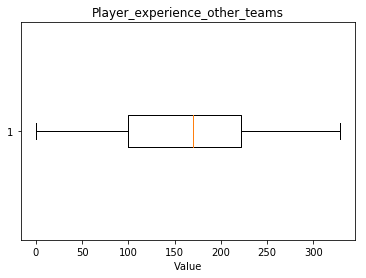

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


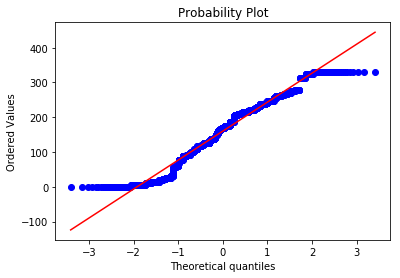

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1886
Kurtosis: -0.7458
Overview of variable:  Player_strategy 


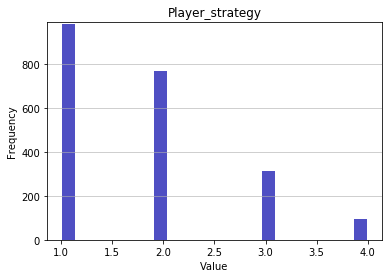

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1
Mean: 1.7778
Standard deviation: 0.8537
Median: 2.0
Maximal value: 4


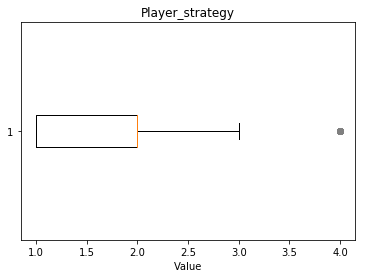

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


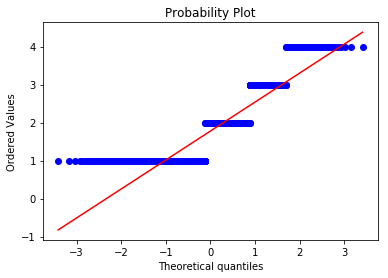

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8703
Kurtosis: -0.0338


<Figure size 432x288 with 0 Axes>

In [48]:
# Univariate analysis of data distribution
for col, col_type in zip(synergy_param_df.columns, synergy_param_df.dtypes):
    if str(col_type) == 'object':
        SummaryCategoricalVar(synergy_param_df[col], col)
    else:
        SummaryNumericVar(synergy_param_df[col].dropna(), col)

### 3.4 Combine all features in one dataframe

In [49]:
# Join dataframes for training data
df_train_tmp = pd.merge(synergy_param_df, team_strenght_df, on=['Team'], how ='left')
feature_train_model2_df = pd.merge(df_train_tmp, player_strenght_df, on=['Player'], how ='left')
feature_train_model2_df.rename(columns= {'Team': 'team', 'Player': 'player', 'player_position': 'position'}, inplace=True)
feature_train_model2_df.head(5)

,team,player,Player_experience_current_team,Player_experience_teamcomposition,Player_experience_general,Player_experience_other_teams,Player_strategy,team_lasso,player_lasso,position
0,team flash,licorice,NaN,NaN,172,172,2,NaN,0.824301,top
1,team flash,svenskeren,NaN,NaN,233,233,2,NaN,0.882607,jungle
2,team flash,goldenglue,NaN,NaN,103,103,2,NaN,0.427780,middle
3,team flash,goldenglue,NaN,NaN,103,103,2,NaN,0.156335,adc
4,team flash,sneaky,NaN,NaN,237,237,1,NaN,0.999997,middle


In [50]:
# Investigate column types
feature_train_model2_df.columns.to_series().groupby(feature_train_model2_df.dtypes).groups

{dtype('int64'): Index(['Player_experience_general', 'Player_experience_other_teams',
        'Player_strategy'],
       dtype='object'),
 dtype('float64'): Index(['Player_experience_current_team', 'Player_experience_teamcomposition',
        'team_lasso', 'player_lasso'],
       dtype='object'),
 dtype('O'): Index(['team', 'player', 'position'], dtype='object')}

## 4. Add global information to final dataframe
* Connect the result of the game played to the strength and experience parameters extracted in previous phase.
* Add information from the global features to each game

In [123]:
# Extract dataset representing the team and its players, the opponent and the result of the game
model2_df = feature_train_model2_df

In [124]:
column_name_list = ['player_top',
 'Player_experience_current_team_top',
 'Player_experience_teamcomposition_top',
 'Player_experience_general_top',
 'Player_experience_other_teams_top',
 'Player_strategy_top',
 'player_lasso_top',
 'player_jungle',
 'Player_experience_current_team_jungle',
 'Player_experience_teamcomposition_jungle',
 'Player_experience_general_jungle',
 'Player_experience_other_teams_jungle',
 'Player_strategy_jungle',
 'player_lasso_jungle',
 'player_middle',
 'Player_experience_current_team_middle',
 'Player_experience_teamcomposition_middle',
 'Player_experience_general_middle',
 'Player_experience_other_teams_middle',
 'Player_strategy_middle',
 'player_lasso_middle',
 'player_adc',
 'Player_experience_current_team_adc',
 'Player_experience_teamcomposition_adc',
 'Player_experience_general_adc',
 'Player_experience_other_teams_adc',
 'Player_strategy_adc',
 'player_lasso_adc',
 'player_support',
 'Player_experience_current_team_support',
 'Player_experience_teamcomposition_support',
 'Player_experience_general_support',
 'Player_experience_other_teams_support',
 'Player_strategy_support',
 'player_lasso_support', 
 'team_lasso',
 'team']

In [125]:
# Generate df
global_team_values_list = []
for i, team in enumerate(teams_worlds_2019): 
    # Create team-vector
    team_values_list = []
    # Save player info
    if team in playerteam_matching_dict:
        for player in playerteam_matching_dict[team]:
            subdat = model2_df[(model2_df.team == team) & (model2_df.player == player) &  (model2_df.position == playerrole_matching_dict[player])]
            for col_i, col in enumerate(subdat.columns):
                # Create column name list during first iteration
                if 'player' in col.lower():
                    team_values_list.append(list(subdat[col])[0])
                    switch = False
    else:
        for s in range(35):
            team_values_list.append(np.nan)
    # Save team info
    team_values_list.append(list(model2_df[(model2_df.team == team)]['team_lasso'])[0])
    team_values_list.append(list(model2_df[(model2_df.team == team)]['team'])[0])
    # Add info to global team vector
    global_team_values_list.append(team_values_list)

In [126]:
# Visualize dataframe necessary for model_2 structure
model2_train_data_df = pd.DataFrame(global_team_values_list, columns = column_name_list)
model2_train_data_df.head()

,player_top,Player_experience_current_team_top,Player_experience_teamcomposition_top,Player_experience_general_top,Player_experience_other_teams_top,Player_strategy_top,player_lasso_top,player_jungle,Player_experience_current_team_jungle,Player_experience_teamcomposition_jungle,...,player_lasso_adc,player_support,Player_experience_current_team_support,Player_experience_teamcomposition_support,Player_experience_general_support,Player_experience_other_teams_support,Player_strategy_support,player_lasso_support,team_lasso,team
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,team flash
1,licorice,108.0,154.0,172.0,64.0,2.0,0.824301,svenskeren,97.0,154.0,...,0.881102,zeyzal,112.0,154.0,176.0,64.0,2.0,0.875461,0.918419,cloud9
2,bwipo,100.0,140.0,108.0,8.0,2.0,0.865858,broxah,225.0,140.0,...,0.999960,rekkles,220.0,140.0,220.0,0.0,1.0,0.999960,0.886906,fnatic
3,evi,13.0,13.0,23.0,10.0,2.0,0.024571,steal,13.0,13.0,...,0.038842,gaeng,5.0,13.0,11.0,6.0,2.0,0.046428,0.065038,detonation focusme
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,detonator


In [127]:
# Remove irrelevant features
model2_train_data_df = model2_train_data_df.drop(['player_top', 'player_jungle', 'player_adc', 'player_middle', 'player_support'], axis=1)
# Intermediate summary 
print("The final dataset captures", len(model2_train_data_df), "teams.\n")

The final dataset captures 24 teams.



## 5. Correct initialization of missing values

In [128]:
# Copy dataframe
data_preparation = model2_train_data_df.copy()

In [129]:
# Replace missing values with appropriate indicator
data_preparation = data_preparation.replace(to_replace = 'nan', value= np.NaN)
data_preparation = data_preparation.replace(to_replace = ' ', value= np.NaN)

### 5.1 Missing values per columns
Because the importance of the columns might dependent on the position occupied by a player, missing values are analyses in a dataframe independent fashion.

---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of columns with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 3 



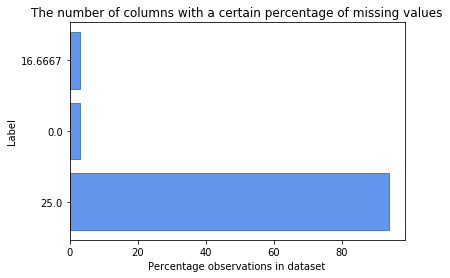

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of columns: 32 

Total number of columns with no missing values: 1 ( 3.125 %)

These are the following columns: ['team'] 

The number of columns for which more than half of the information is missing: 0 ( 0.0 %)

These are the following columns: []


<Figure size 432x288 with 0 Axes>

In [130]:
# Count of columns with a certain number of missing values
percentage_missing_percol = [round(x/len(data_preparation)*100, 4) for x in list(data_preparation.isna().sum())]
SummaryCategoricalVar(percentage_missing_percol,
                      'The number of columns with a certain percentage of missing values')

# Print intermediate summary
print("-"*100, "\nBroader exploration of the data\n", "-"*100)
print("Total number of columns:", len(percentage_missing_percol), "\n")
print("Total number of columns with no missing values:", 
      len([x for x in percentage_missing_percol if x == 0]),
     "(", round(len([x for x in percentage_missing_percol if x == 0])/len(percentage_missing_percol)*100, 4), "%)\n")
print("These are the following columns:", [y for y, x in zip(data_preparation.columns, percentage_missing_percol) if x == 0], "\n")
print("The number of columns for which more than half of the information is missing:", 
      len([x for x in percentage_missing_percol if x > 50]),
     "(", round(len([x for x in percentage_missing_percol if x > 50])/len(percentage_missing_percol)*100, 4), "%)\n")
print("These are the following columns:", [y for y, x in zip(data_preparation.columns, percentage_missing_percol) if x > 50])

In [131]:
# Remove the columns from the data in case more than half of the observations are missing
columns_to_be_dropped = [y for y, x in zip(data_preparation.columns, percentage_missing_percol) if x > 50]
data_preparation = data_preparation.drop(columns_to_be_dropped, axis=1)

# Intermediate summary 
print("After dropping columns with more than half missing values, namely:\n", columns_to_be_dropped)
print(len(data_preparation.columns), "parameters are retained in the dataset.")

After dropping columns with more than half missing values, namely:
 []
32 parameters are retained in the dataset.


### 5.2 Missing values per row

---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 3 



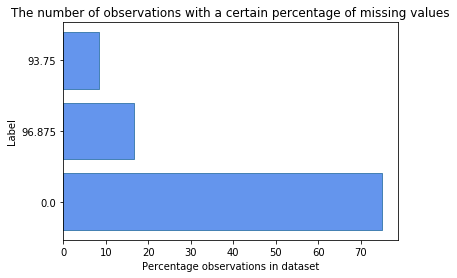

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of observations: 24 

Total number of observations with no missing values: 18 ( 75.0 %)

The number of observations for which more than half of the information is missing: 6 ( 25.0 %)


<Figure size 432x288 with 0 Axes>

In [132]:
# Count of rows with a certain number of missing values
percentage_missing_perobs = [round(x/len(data_preparation.columns)*100, 4) for x in list(data_preparation.isna().sum(axis=1))]
SummaryCategoricalVar(percentage_missing_perobs,
                      'The number of observations with a certain percentage of missing values')

# Print intermediate summary
print("-"*100, "\nBroader exploration of the data\n", "-"*100)
print("Total number of observations:", len(percentage_missing_perobs), "\n")
print("Total number of observations with no missing values:", 
      len([x for x in percentage_missing_perobs if x == 0]),
     "(", round(len([x for x in percentage_missing_perobs if x == 0])/len(percentage_missing_perobs)*100, 4), "%)\n")
print("The number of observations for which more than half of the information is missing:", 
      len([x for x in percentage_missing_perobs if x > 50]),
     "(", round(len([x for x in percentage_missing_perobs if x > 50])/len(percentage_missing_perobs)*100, 4), "%)")

### 5.3 Missing value imputation
To impute missing values the following techniques are applied:
* Categorical covariates: random sampling from the discrete distribution representing the probabilities of a value being from a 
certain category for that covariate. Because of the large amount of data available, it might be interesting to do imputation by sampling randomly from the distribution of available values for a specific covariate, to obtain the least biased estimation of the missing value. It is nevertheless important to get a clear insight into the data with a lot of missing data as well, because these could be biased towards certain column values and hence should be treated with care.
* Numerical covariates: Quantile based imputation. Latter imputation technique was considered to avoid an overestimation of strength from the teams of the challenger series enteringg the competition.

In [133]:
# Initialization
q = 0.15

# Probability based missing value imptation (categorical covariates) and median imputation (numerical covariates)
for col, col_type in zip(data_preparation.columns, data_preparation.dtypes):
    if str(col_type) != 'object' and data_preparation[col].isna().sum() > 0:
        data_preparation[col] = data_preparation[col].fillna(data_preparation[col].dropna().quantile(q))
    elif data_preparation[col].isna().sum() > 0:
        data_preparation[col] = data_preparation[col].fillna(RandomSampleProbDist(data_preparation[col].dropna()))

In [134]:
# Check whether there are still non-imputed missing values in the data
np.any(data_preparation.isnull())

False

## 6. Write untransformed data away

In [135]:
# Write data away in pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename + '.pickle', 'wb') as f:
    pickle.dump(data_preparation, f)

## 7. Transform data

In [136]:
# Define the columns to exclude
data = data_preparation.copy()
excluded_columns = ['team']
columns_in_scope = list(set(data.columns) - set(excluded_columns))

player_lasso_adc
Feature:  player_lasso_adc
The optimal value for lambda:  0.8723652669107697
player_lasso_jungle
Feature:  player_lasso_jungle
The optimal value for lambda:  0.9284153618519193
Player_experience_current_team_middle
Feature:  Player_experience_current_team_middle
The optimal value for lambda:  0.1346005352877018
Player_experience_teamcomposition_support
Feature:  Player_experience_teamcomposition_support
The optimal value for lambda:  0.6589153982489707
Player_experience_teamcomposition_middle
Feature:  Player_experience_teamcomposition_middle
The optimal value for lambda:  0.6589153982489707
Player_experience_current_team_top
Feature:  Player_experience_current_team_top
The optimal value for lambda:  0.5245074565063343
Player_experience_other_teams_adc
team_lasso
Feature:  team_lasso
The optimal value for lambda:  0.975753451663758
Player_strategy_adc
Feature:  Player_strategy_adc
The optimal value for lambda:  -3.1005330888179956
player_lasso_top
Feature:  player_lass

/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The optimal value for lambda:  -1.5230272588462017
Player_experience_current_team_jungle
Feature:  Player_experience_current_team_jungle
The optimal value for lambda:  0.43141942657722393
Player_experience_current_team_adc
Feature:  Player_experience_current_team_adc


/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The optimal value for lambda:  0.6195277014626371
Player_experience_general_support
Feature:  Player_experience_general_support
The optimal value for lambda:  0.5343654288511127
player_lasso_support
Feature:  player_lasso_support


/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The optimal value for lambda:  0.7674982774178296
Player_experience_other_teams_support
Player_experience_general_adc
Feature:  Player_experience_general_adc
The optimal value for lambda:  0.9726588305377063


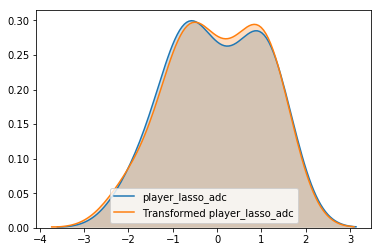

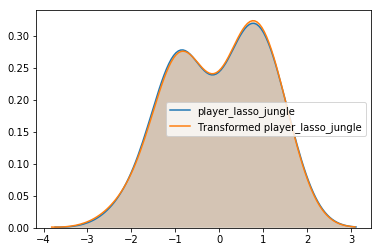

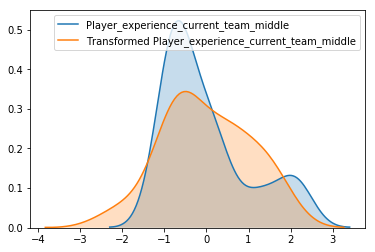

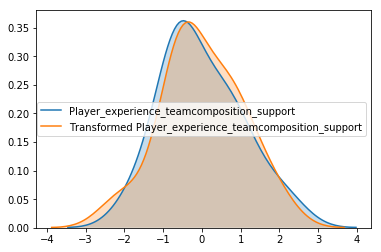

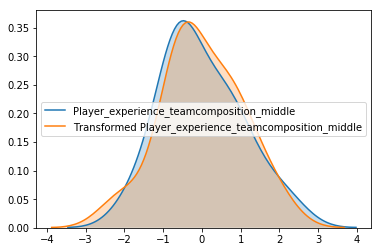

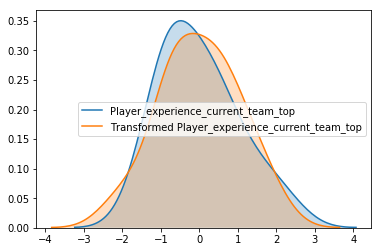

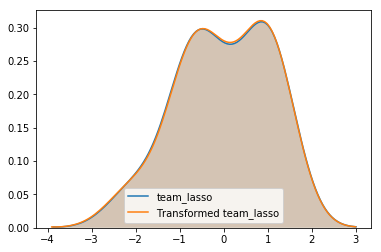

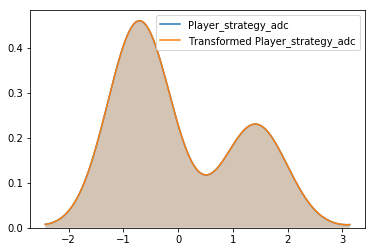

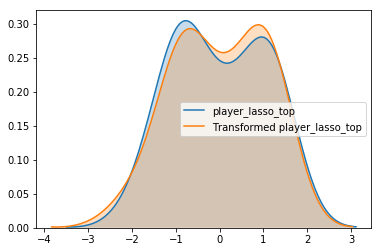

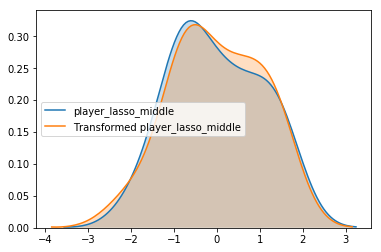

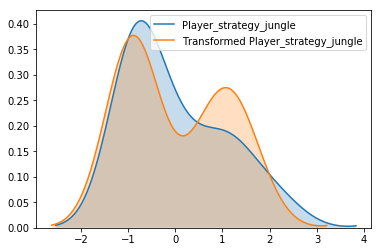

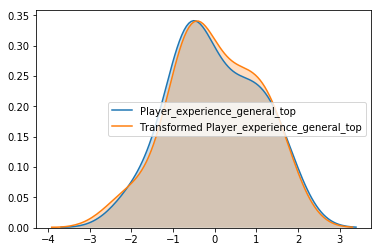

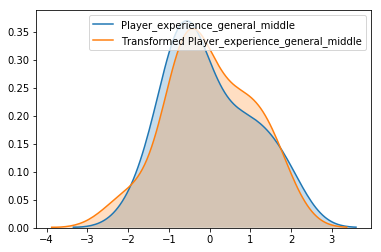

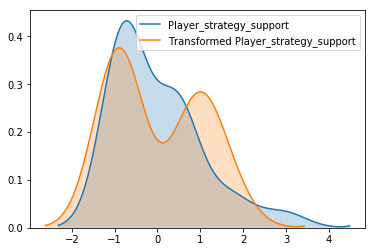

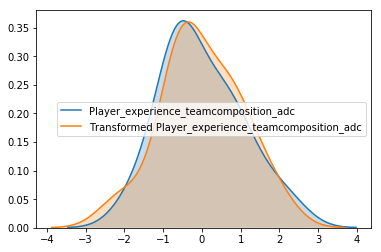

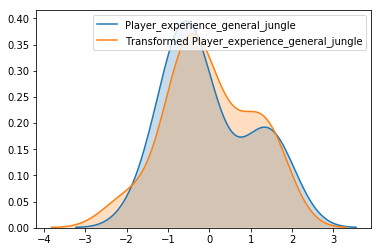

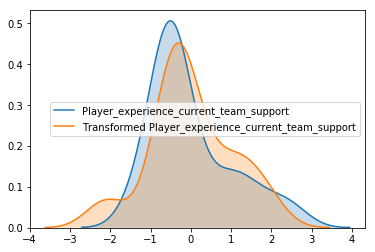

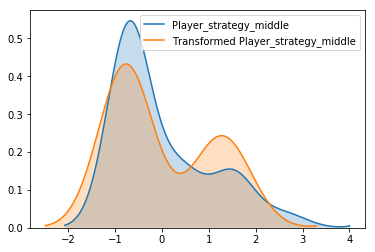

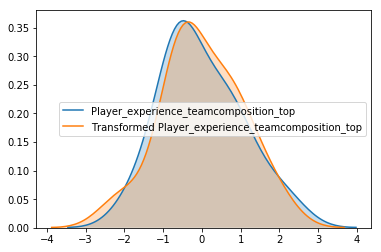

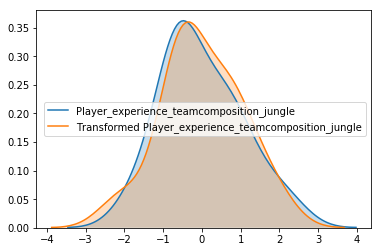

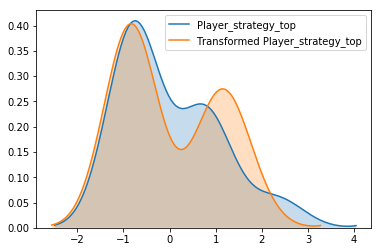

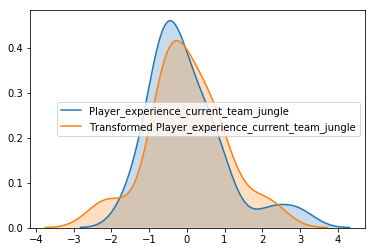

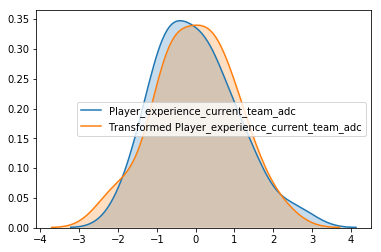

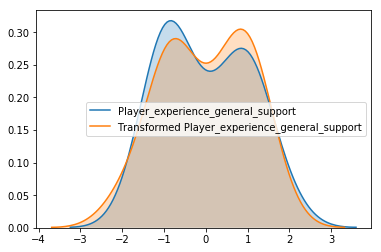

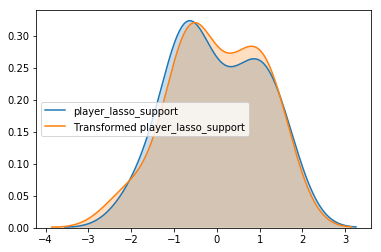

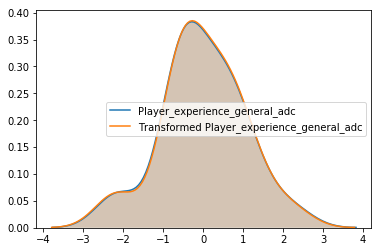

In [137]:
# Initialization
transformed_train_data_df, optimiser_dict = pd.DataFrame(), dict()

# Loop through the data and apply box cox transformation
for num_variable in columns_in_scope:
    print(num_variable)
    if all(data[num_variable] > 0):
        transformed_feature, optimiser = feature_transformer(data[num_variable], num_variable)
        if -5 <= optimiser <= 5:
            transformed_train_data_df[num_variable] = transformed_feature
            optimiser_dict[num_variable] = optimiser
        else:
            transformed_train_data_df[num_variable] = preprocessing.scale(data[num_variable])
            optimiser_dict[num_variable] = np.nan
    else:
        transformed_train_data_df[num_variable] = preprocessing.scale(data[num_variable])
        
# Add result feature
transformed_train_data_df['Team'] = list(data['team'])

Overview of variable:  player_lasso_adc 


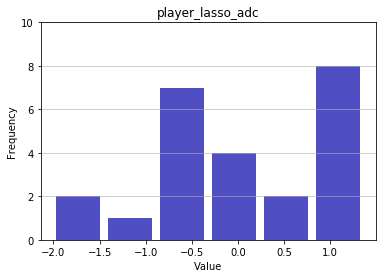

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.0145773347161926
Mean: -0.0
Standard deviation: 1.0215
Median: -0.0153
Maximal value: 1.371253932737603


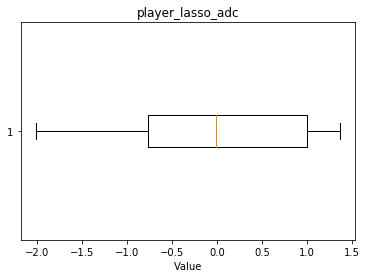

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


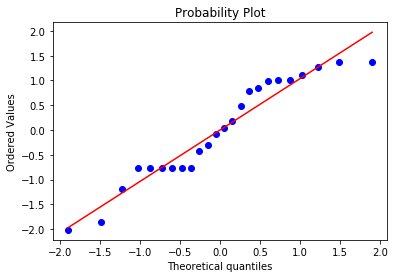

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.262
Kurtosis: -1.0087
Overview of variable:  player_lasso_jungle 


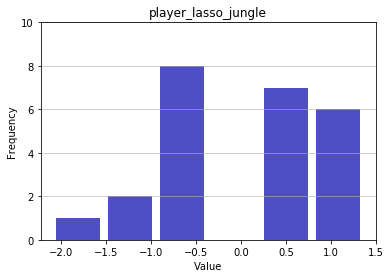

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.0965612066042
Mean: -0.0
Standard deviation: 1.0215
Median: 0.4469
Maximal value: 1.3699894418740841


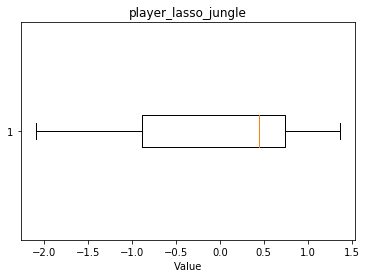

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


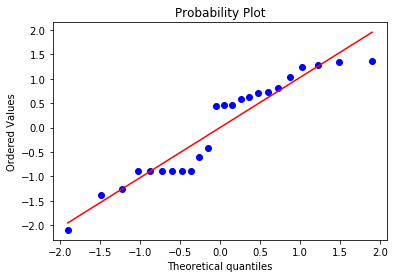

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2581
Kurtosis: -1.1902
Overview of variable:  Player_experience_current_team_middle 


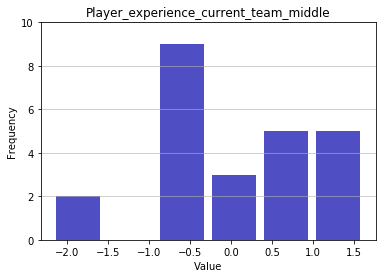

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1828763829517195
Mean: -0.0
Standard deviation: 1.0215
Median: -0.1074
Maximal value: 1.621970349070033


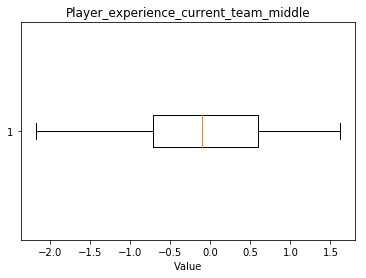

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


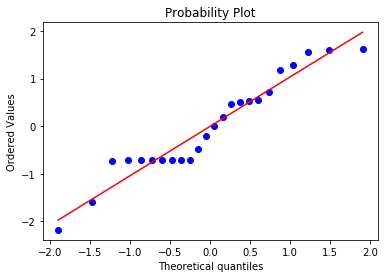

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0277
Kurtosis: -0.6626
Overview of variable:  Player_experience_teamcomposition_support 


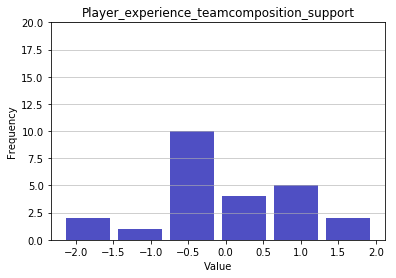

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1836560989729428
Mean: -0.0
Standard deviation: 1.0215
Median: -0.3066
Maximal value: 1.9770915016481423


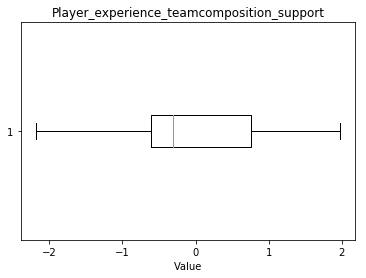

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


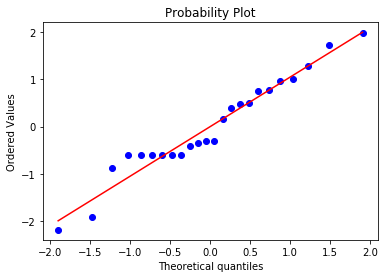

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0661
Kurtosis: -0.2331
Overview of variable:  Player_experience_teamcomposition_middle 


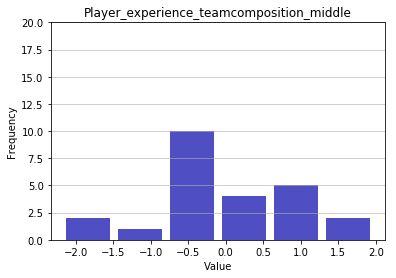

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1836560989729428
Mean: -0.0
Standard deviation: 1.0215
Median: -0.3066
Maximal value: 1.9770915016481423


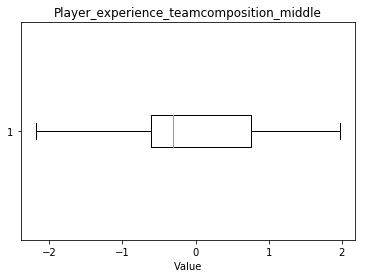

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


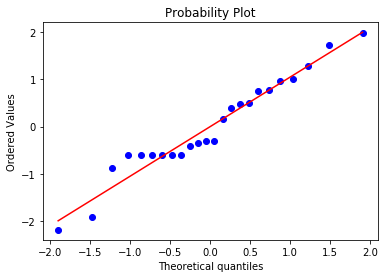

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0661
Kurtosis: -0.2331
Overview of variable:  Player_experience_current_team_top 


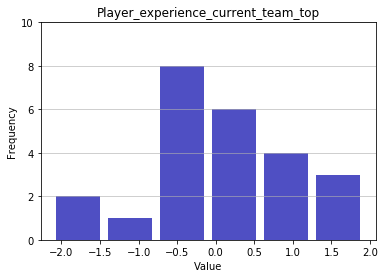

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1204574687284024
Mean: 0.0
Standard deviation: 1.0215
Median: 0.1335
Maximal value: 1.9265994337384589


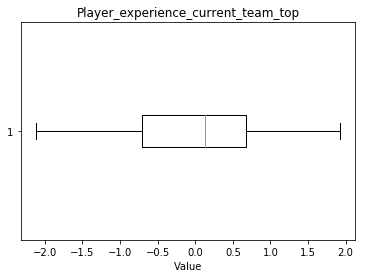

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


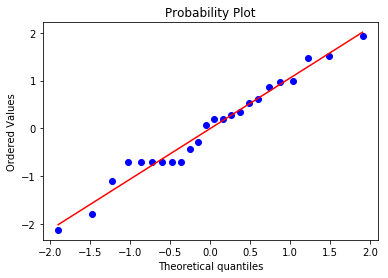

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0858
Kurtosis: -0.4957
Overview of variable:  Player_experience_other_teams_adc 


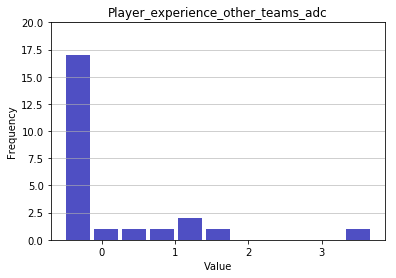

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5196133566108657
Mean: 0.0
Standard deviation: 1.0215
Median: -0.5196
Maximal value: 3.6873767113710834


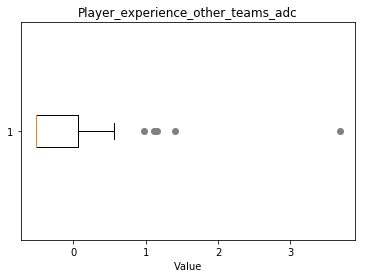

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.69}


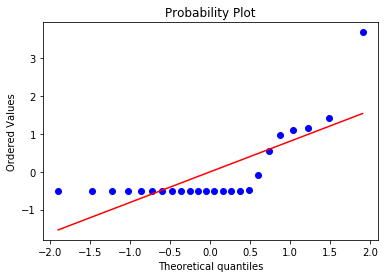

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 2.2751
Kurtosis: 5.0988
Overview of variable:  team_lasso 


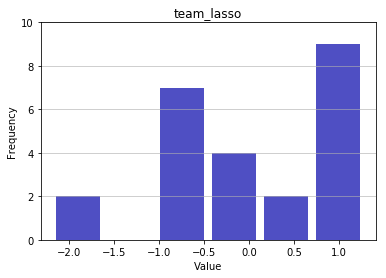

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1871464624919033
Mean: -0.0
Standard deviation: 1.0215
Median: -0.1341
Maximal value: 1.2787076775922441


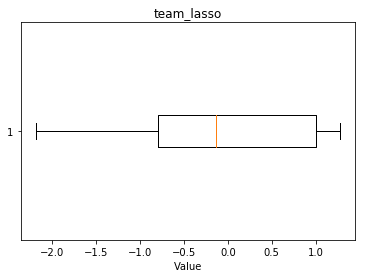

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


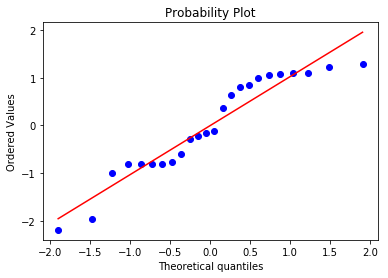

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4325
Kurtosis: -0.7722
Overview of variable:  Player_strategy_adc 


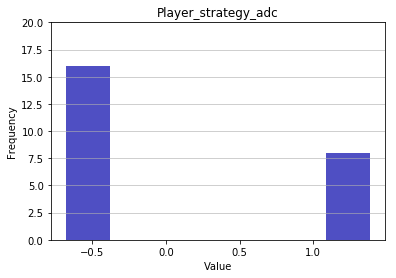

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7071067811865477
Mean: -0.0
Standard deviation: 1.0215
Median: -0.7071
Maximal value: 1.4142135623730951


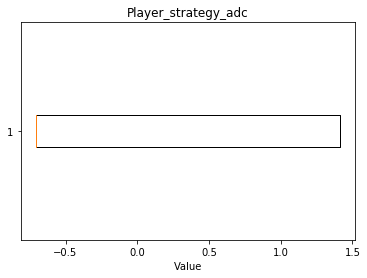

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


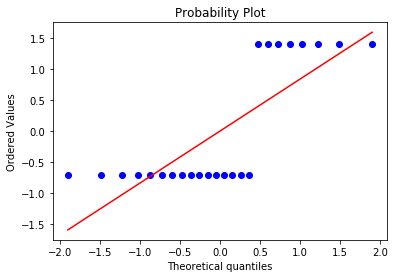

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7071
Kurtosis: -1.5
Overview of variable:  player_lasso_top 


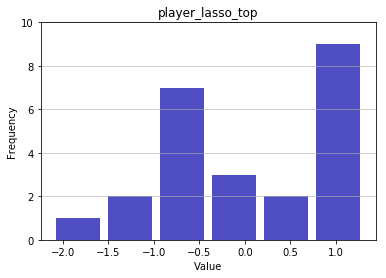

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1156694706471786
Mean: 0.0
Standard deviation: 1.0215
Median: 0.0706
Maximal value: 1.312088680525953


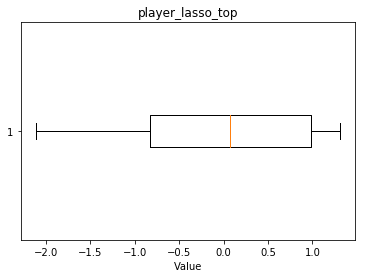

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


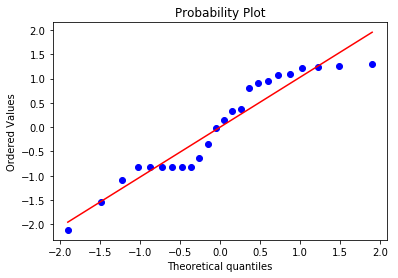

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2259
Kurtosis: -1.1335
Overview of variable:  player_lasso_middle 


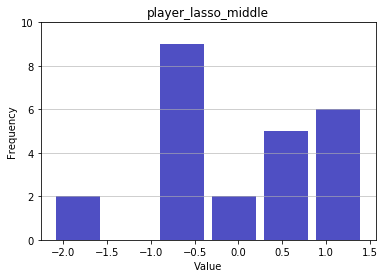

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1282531992791753
Mean: 0.0
Standard deviation: 1.0215
Median: 0.042
Maximal value: 1.436786615016666


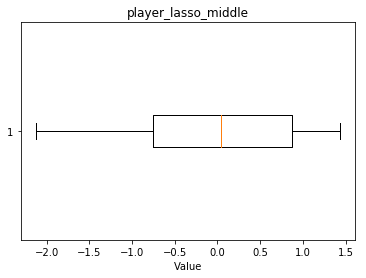

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


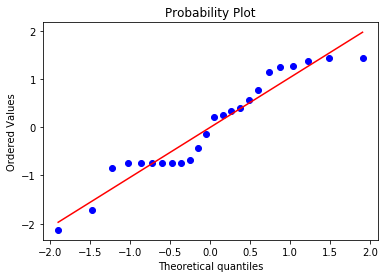

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1447
Kurtosis: -0.8723
Overview of variable:  Player_experience_other_teams_jungle 


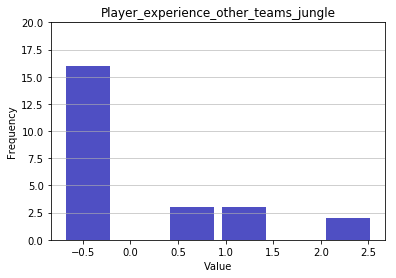

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7174573855427976
Mean: 0.0
Standard deviation: 1.0215
Median: -0.7175
Maximal value: 2.5594401767945194


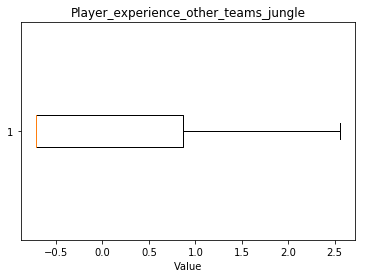

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


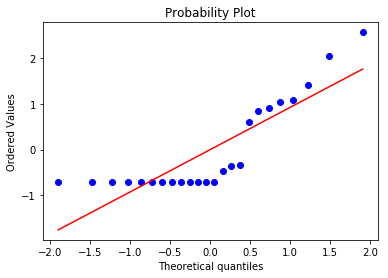

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1281
Kurtosis: -0.01
Overview of variable:  Player_strategy_jungle 


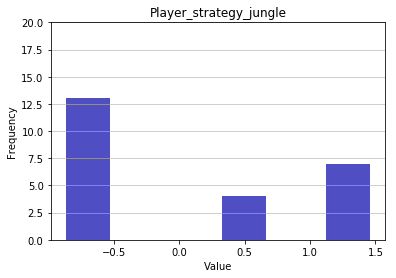

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8983552822829081
Mean: 0.0
Standard deviation: 1.0215
Median: -0.8984
Maximal value: 1.489771784869068


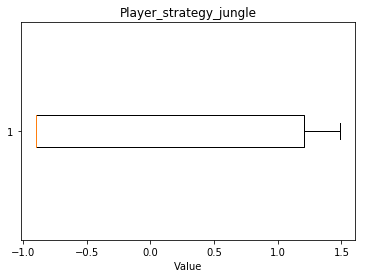

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


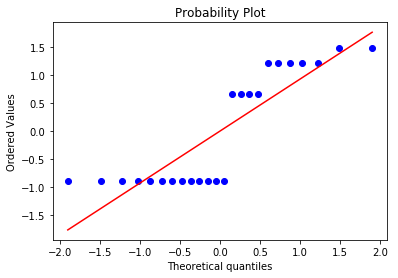

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2997
Kurtosis: -1.7593
Overview of variable:  Player_experience_other_teams_middle 


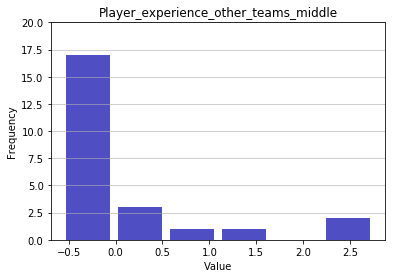

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5728554239107441
Mean: 0.0
Standard deviation: 1.0215
Median: -0.5729
Maximal value: 2.7570008229412215


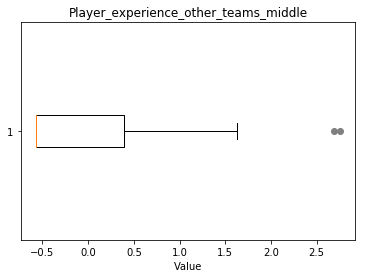

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


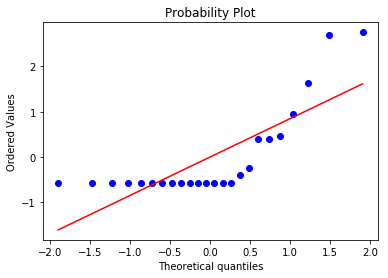

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.7836
Kurtosis: 1.9781
Overview of variable:  Player_experience_general_top 


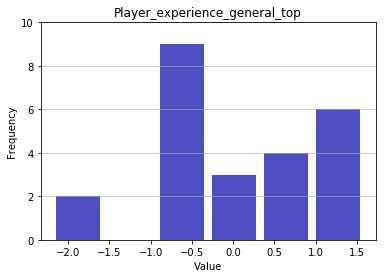

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.195387161202713
Mean: 0.0
Standard deviation: 1.0215
Median: -0.2602
Maximal value: 1.590125038238571


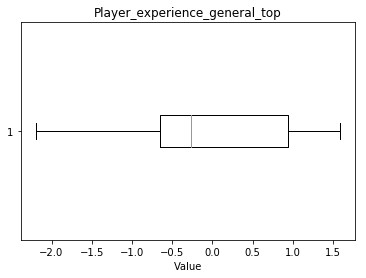

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


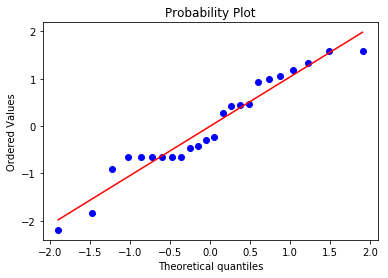

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1731
Kurtosis: -0.6052
Overview of variable:  Player_experience_general_middle 


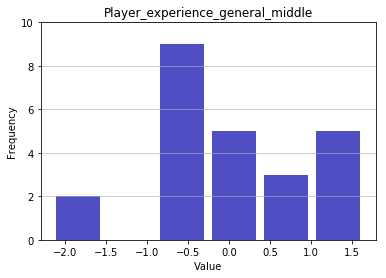

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.159263338031913
Mean: 0.0
Standard deviation: 1.0215
Median: -0.2201
Maximal value: 1.6477945624126493


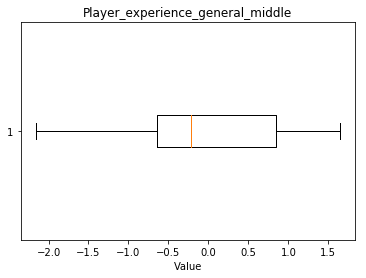

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


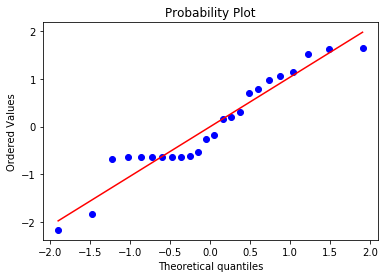

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0739
Kurtosis: -0.563
Overview of variable:  Player_strategy_support 


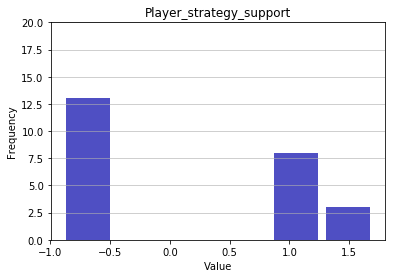

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.9016335994291148
Mean: 0.0
Standard deviation: 1.0215
Median: -0.9016
Maximal value: 1.7072566984017825


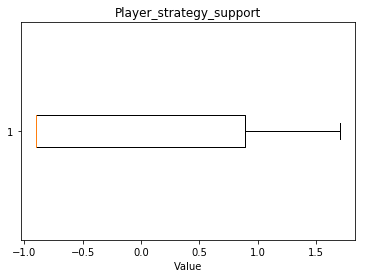

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


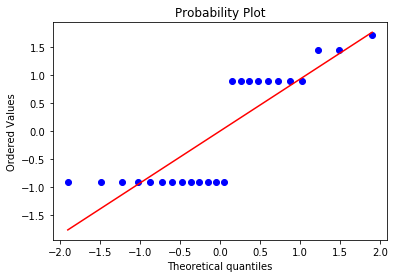

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2967
Kurtosis: -1.7161
Overview of variable:  Player_experience_teamcomposition_adc 


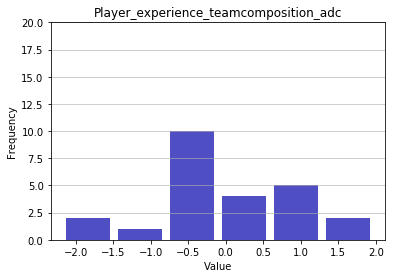

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1836560989729428
Mean: -0.0
Standard deviation: 1.0215
Median: -0.3066
Maximal value: 1.9770915016481423


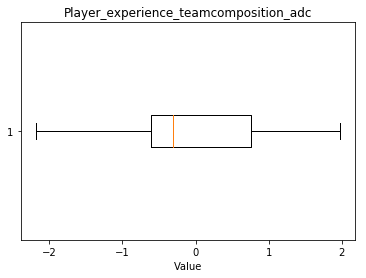

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


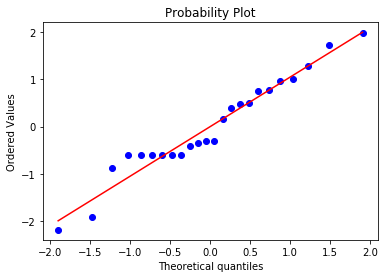

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0661
Kurtosis: -0.2331
Overview of variable:  Player_experience_general_jungle 


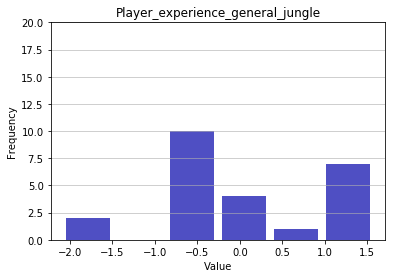

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.094561475328669
Mean: -0.0
Standard deviation: 1.0215
Median: -0.2244
Maximal value: 1.5798901713881885


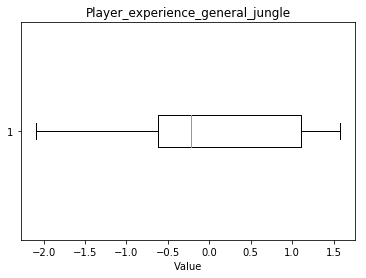

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


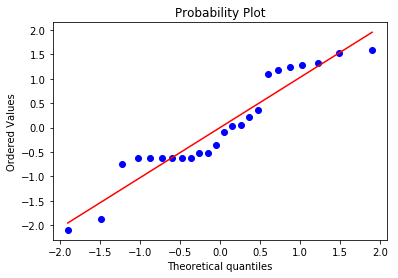

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0414
Kurtosis: -0.6513
Overview of variable:  Player_experience_current_team_support 


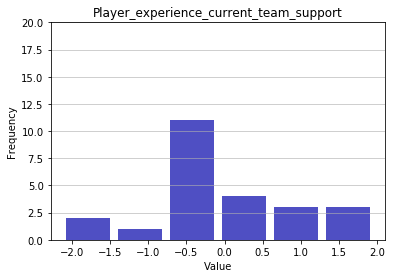

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.136536919191561
Mean: -0.0
Standard deviation: 1.0215
Median: -0.2086
Maximal value: 1.9648260458681515


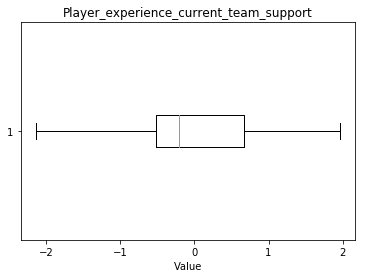

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


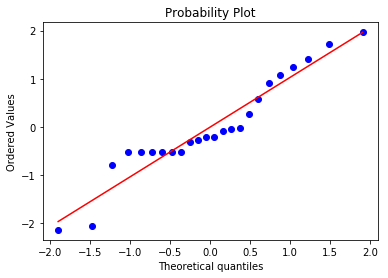

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0019
Kurtosis: -0.0175
Overview of variable:  Player_strategy_middle 


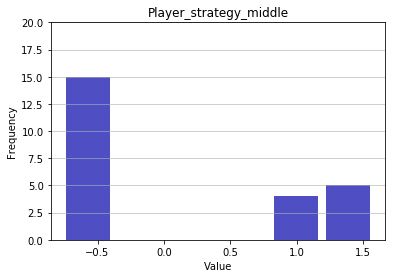

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7681267052503152
Mean: -0.0
Standard deviation: 1.0215
Median: -0.7681
Maximal value: 1.5815728661868205


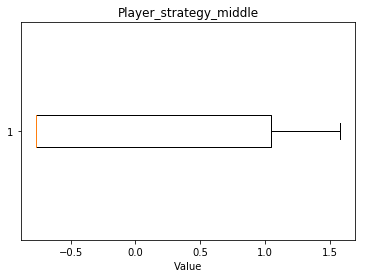

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


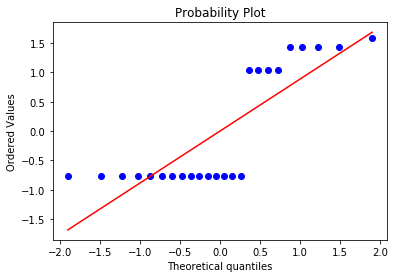

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.5672
Kurtosis: -1.612
Overview of variable:  Player_experience_teamcomposition_top 


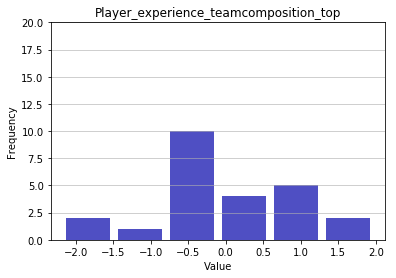

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1836560989729428
Mean: -0.0
Standard deviation: 1.0215
Median: -0.3066
Maximal value: 1.9770915016481423


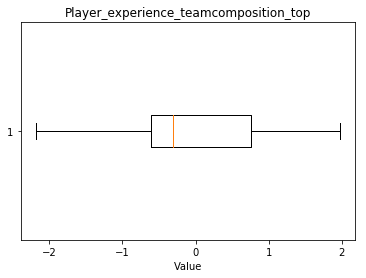

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


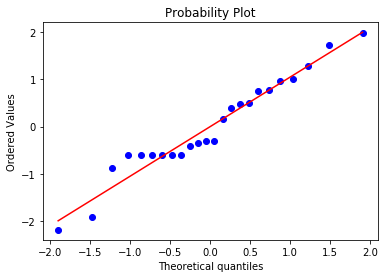

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0661
Kurtosis: -0.2331
Overview of variable:  Player_experience_other_teams_top 


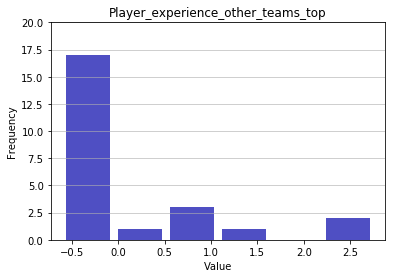

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.6069170742887462
Mean: -0.0
Standard deviation: 1.0215
Median: -0.6069
Maximal value: 2.757875459154029


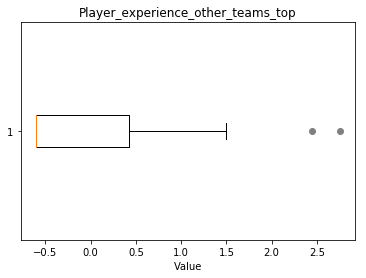

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


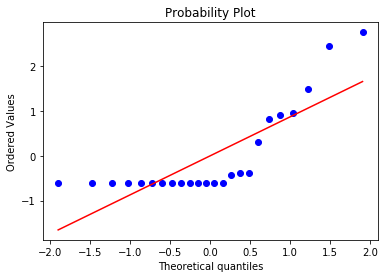

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.5794
Kurtosis: 1.2821
Overview of variable:  Player_experience_teamcomposition_jungle 


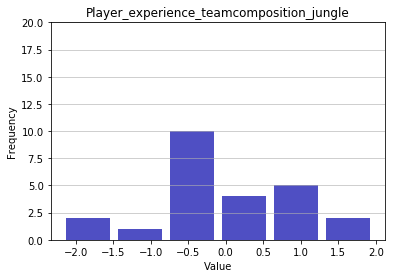

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1836560989729428
Mean: -0.0
Standard deviation: 1.0215
Median: -0.3066
Maximal value: 1.9770915016481423


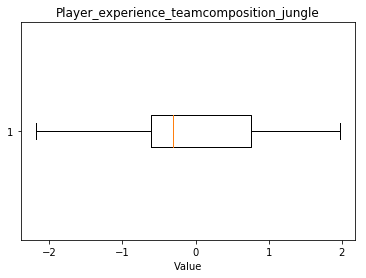

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


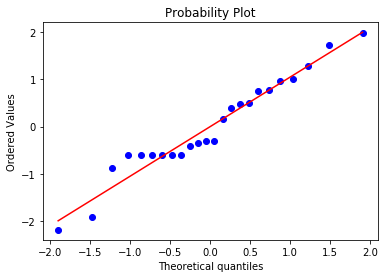

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0661
Kurtosis: -0.2331
Overview of variable:  Player_strategy_top 


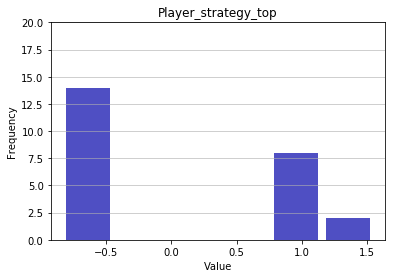

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8388603145354362
Mean: 0.0
Standard deviation: 1.0215
Median: -0.8389
Maximal value: 1.5518322202685242


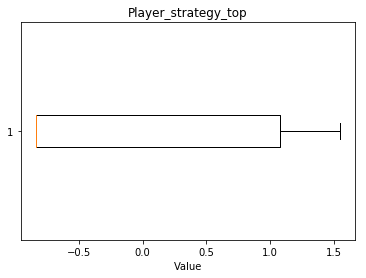

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


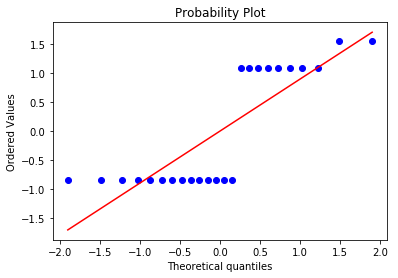

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.387
Kurtosis: -1.7743
Overview of variable:  Player_experience_current_team_jungle 


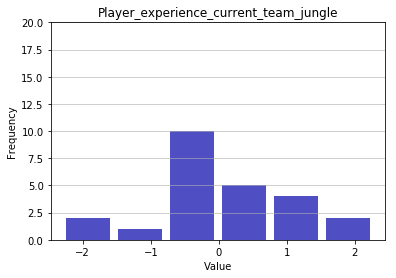

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.3065163255943624
Mean: -0.0
Standard deviation: 1.0215
Median: -0.096
Maximal value: 2.2824419809762744


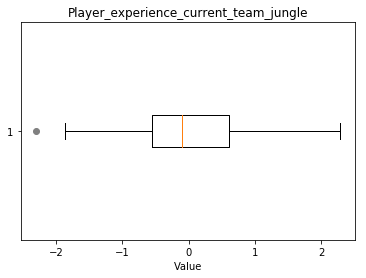

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


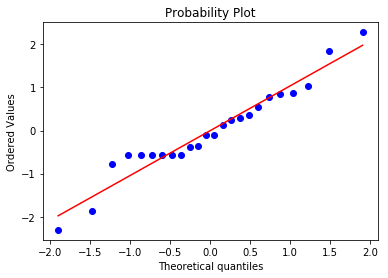

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0394
Kurtosis: 0.4674
Overview of variable:  Player_experience_current_team_adc 


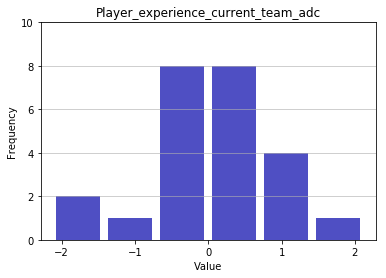

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1279842855365136
Mean: 0.0
Standard deviation: 1.0215
Median: 0.1313
Maximal value: 2.1278059053944194


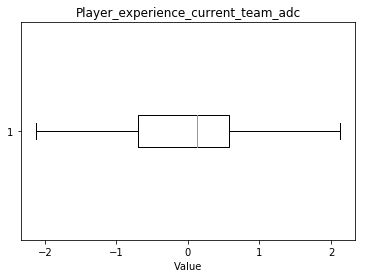

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


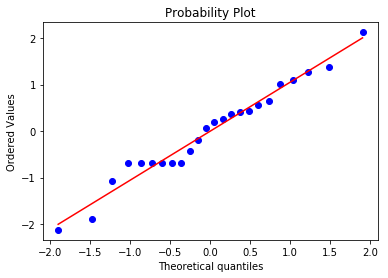

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0918
Kurtosis: -0.2597
Overview of variable:  Player_experience_general_support 


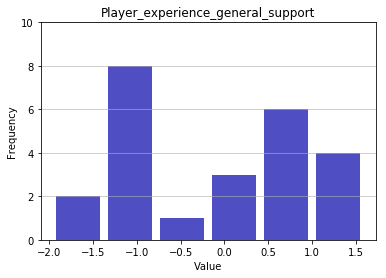

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.966472055855926
Mean: 0.0
Standard deviation: 1.0215
Median: 0.1173
Maximal value: 1.596430511682414


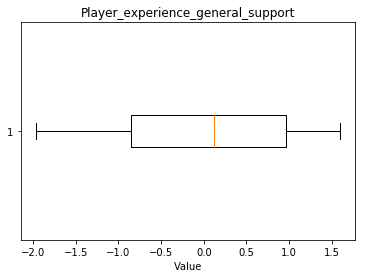

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


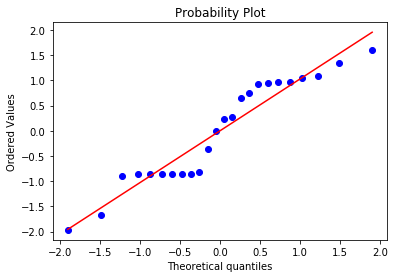

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.1731
Kurtosis: -1.1992
Overview of variable:  player_lasso_support 


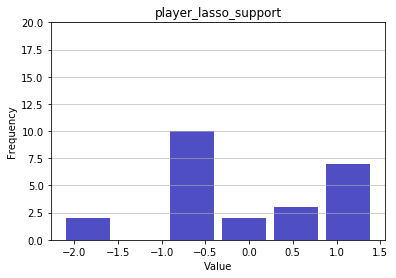

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.1388705154319894
Mean: -0.0
Standard deviation: 1.0215
Median: -0.1126
Maximal value: 1.4288394902572665


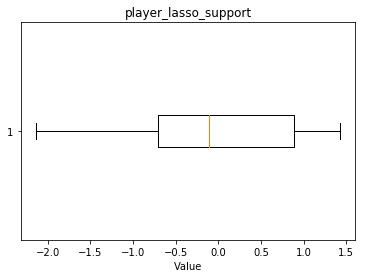

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


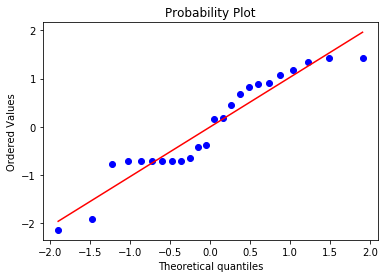

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2602
Kurtosis: -0.7902
Overview of variable:  Player_experience_other_teams_support 


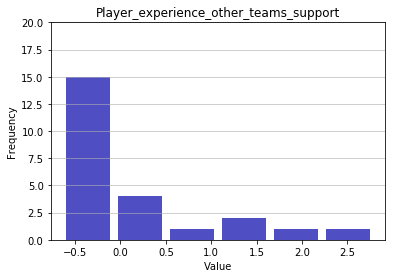

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.6459235840387618
Mean: 0.0
Standard deviation: 1.0215
Median: -0.6459
Maximal value: 2.7954616776847137


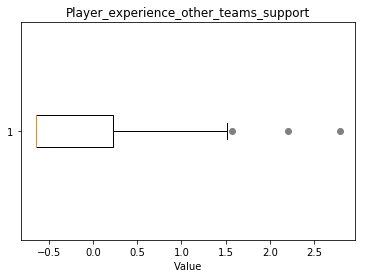

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


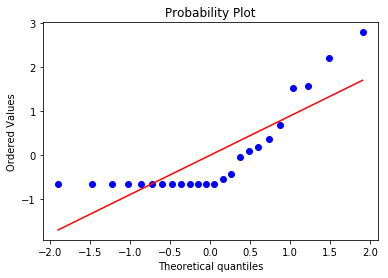

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.5242
Kurtosis: 1.1155
Overview of variable:  Player_experience_general_adc 


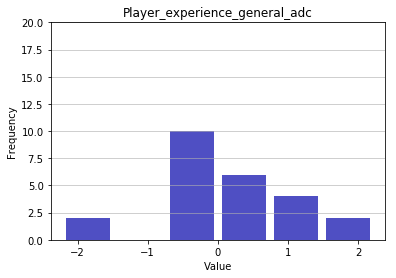

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.224274912929339
Mean: -0.0
Standard deviation: 1.0215
Median: -0.0349
Maximal value: 2.2285323453350623


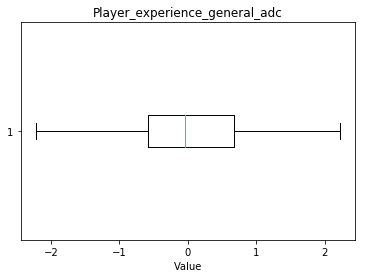

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


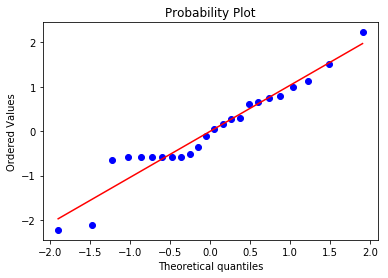

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.155
Kurtosis: 0.301


<Figure size 432x288 with 0 Axes>

In [138]:
# Loop through all numerical variables and visualize data
for num_variable in columns_in_scope:
    SummaryNumericVar(transformed_train_data_df[num_variable], num_variable)

In [139]:
# Write data away in pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + preprocessed_filename + '.pickle', 'wb') as f:
    pickle.dump(transformed_train_data_df, f)